This notebook is for creating graphs of the benchmark case study, specifically using datasets where all the data is available.

Currently this notebook resides in the `notebooks` folder, but in order for it to run, it must be moved out to the main folder. 

# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import aesara.tensor as at

import cobra
import os
os.getcwd()

from scipy import stats
import scipy as sp

from src import BMCA, util
import emll


WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Perturbing boundary metabolites, specifically EtOH

First, we use data where [EtOH] is perturbed

In [2]:
# elasticity_to_CCC(BIOMD64, r.getScaledElasticityMatrix())
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/EtOHcompilation.csv'
data = pd.read_csv(data_file)

r = te.loada(Teusink_ant)

r.conservedMoietyAnalysis = True
r.steadyState()
scaledE = r.getScaledElasticityMatrix()

In [3]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

Model does not contain SBML fbc package information.


Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-10-19


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

## Running ADVI

In [4]:
import numpy as np
import pymc as pm
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [5]:
with pymc_model:
    
    # e_obs = pm.Normal('e_obs', mu=BIOMD64.en.T, sigma=0.1)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BIOMD64.xn.T)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BIOMD64.yn.T)

    likelihood = pm.Deterministic('vn', (np.ones((17,30)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)

pymc_model.free_RVs

[Ex_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ex_capacity_entries ~ Laplace(0, 0.01),
 Ey_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ey_capacity_entries ~ Laplace(0, 0.01)]

In [6]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=       N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)
    

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,681.1
Sampling: [chi_obs, v_hat_obs, y_obs]


### Plotting ADVI results

In [7]:
Ex_trace = (trace_vi['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)

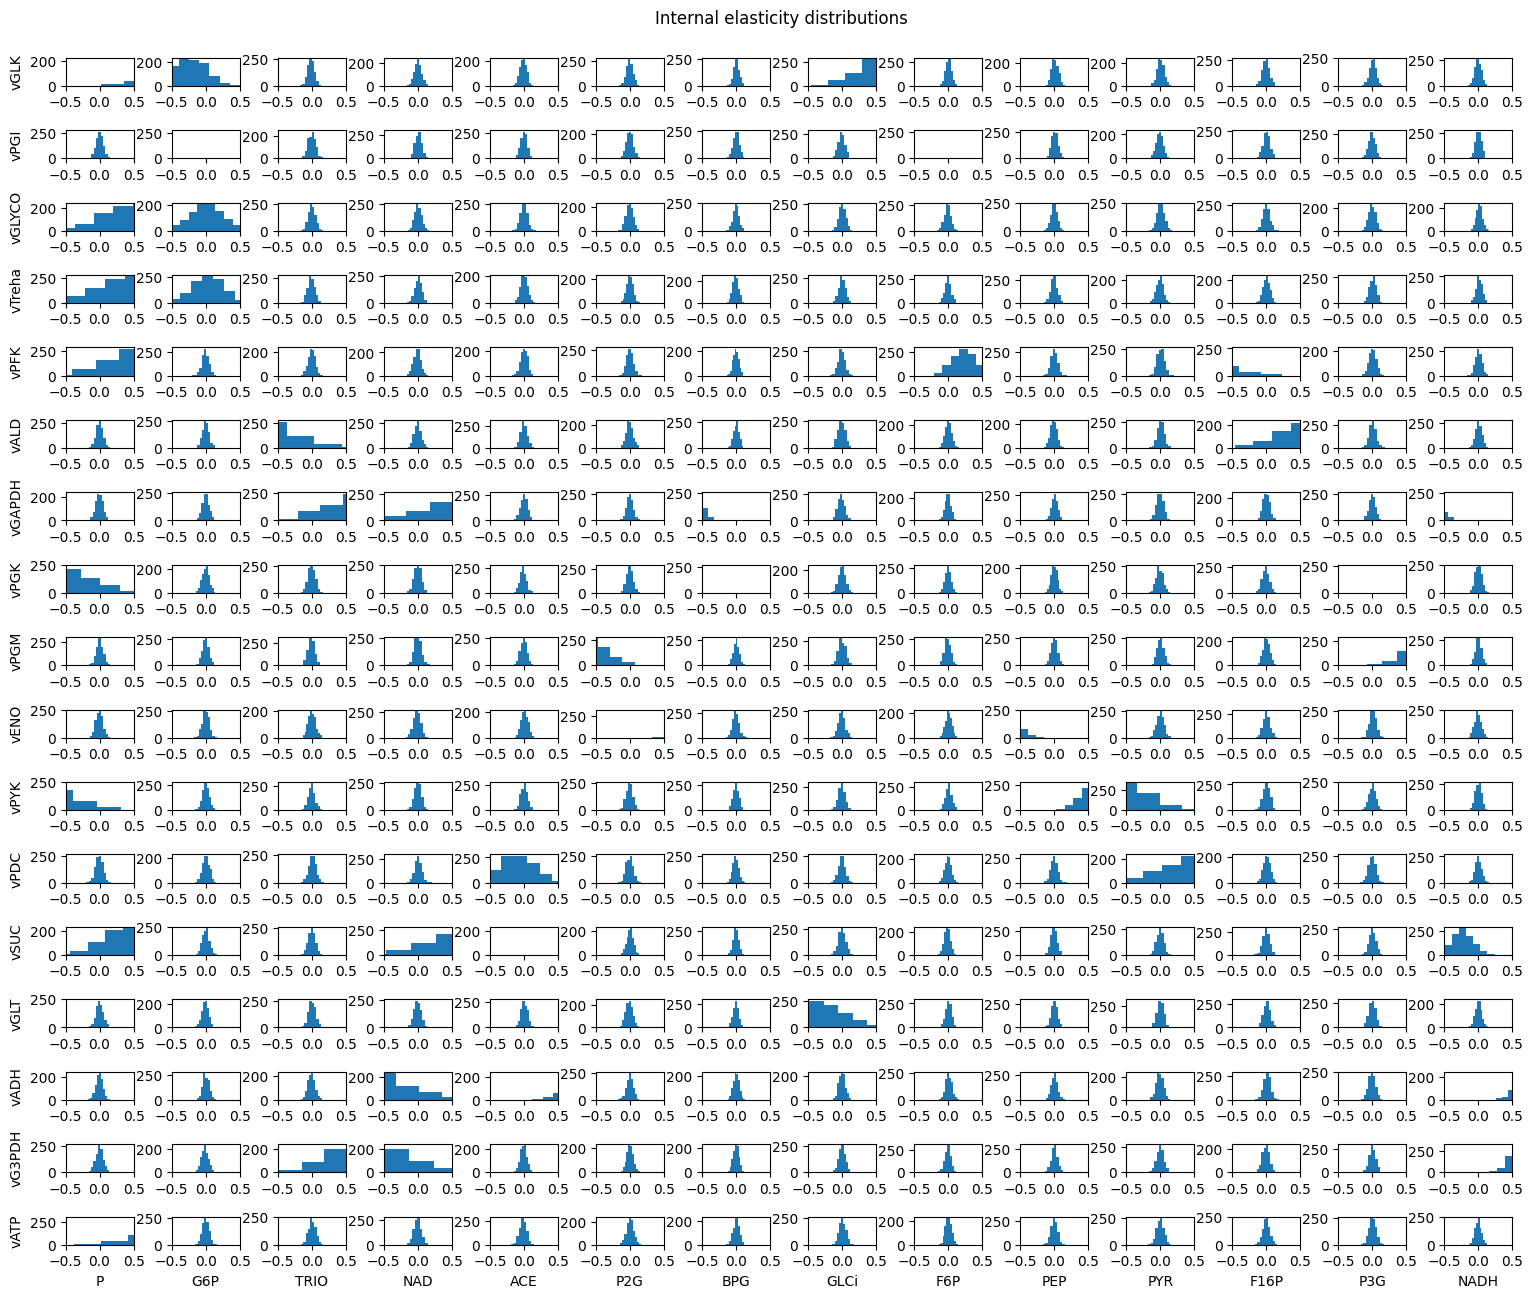

In [8]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(14):
    axs[i,ii].hist(Ex_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

all distributions are unimodal so we estimate that the peak of the distribution is the median

In [9]:
Ex_peaks=[]

for i in range(Ex_trace.shape[0]):
    for ii in range(Ex_trace.shape[1]):
        Ex_peaks.append(np.percentile(Ex_trace[i,ii,:],50))


In [10]:
# these are the elasticity posteriors from Bayesian inference
x = np.array(Ex_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
x[abs(x) < 0.01] = 0

x = x.reshape((17,14))
Ex = pd.DataFrame(x, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())
Ex

,P,G6P,TRIO,NAD,ACE,P2G,BPG,GLCi,F6P,PEP,PYR,F16P,P3G,NADH
vGLK,1.593898,-0.230010,-0.011974,0.000000,-0.010910,0.000000,0.000000,0.559251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vPGI,0.000000,1.891299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.177590,0.000000,0.000000,0.000000,0.000000,0.000000
vGLYCO,0.541057,0.015154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010016
vTreha,0.415592,0.048586,0.000000,0.010179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011191
vPFK,0.625643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.234529,0.000000,0.000000,-1.319057,0.000000,0.000000
vALD,0.000000,0.000000,-0.860707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.682044,0.000000,0.000000
vGAPDH,0.000000,0.000000,0.808778,0.778693,0.000000,0.000000,-0.631922,-0.011154,0.000000,0.000000,0.000000,0.000000,0.000000,-0.726226
vPGK,-0.632677,0.000000,0.000000,0.000000,0.000000,0.000000,0.958344,0.000000,0.000000,0.000000,-0.011242,0.000000,-1.884764,0.000000
vPGM,0.000000,0.000000,0.000000,0.000000,0.000000,-0.611953,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.876603,0.000000
vENO,0.000000,0.000000,0.000000,0.000000,0.000000,1.345475,0.000000,0.000000,0.000000,-0.740767,0.000000,0.000000,0.000000,0.000000


In [11]:
Ey_trace = (trace_vi['posterior']['Ey']).to_numpy().squeeze().transpose(1, 2, 0)
Ey_trace.shape

(17, 5, 1000)

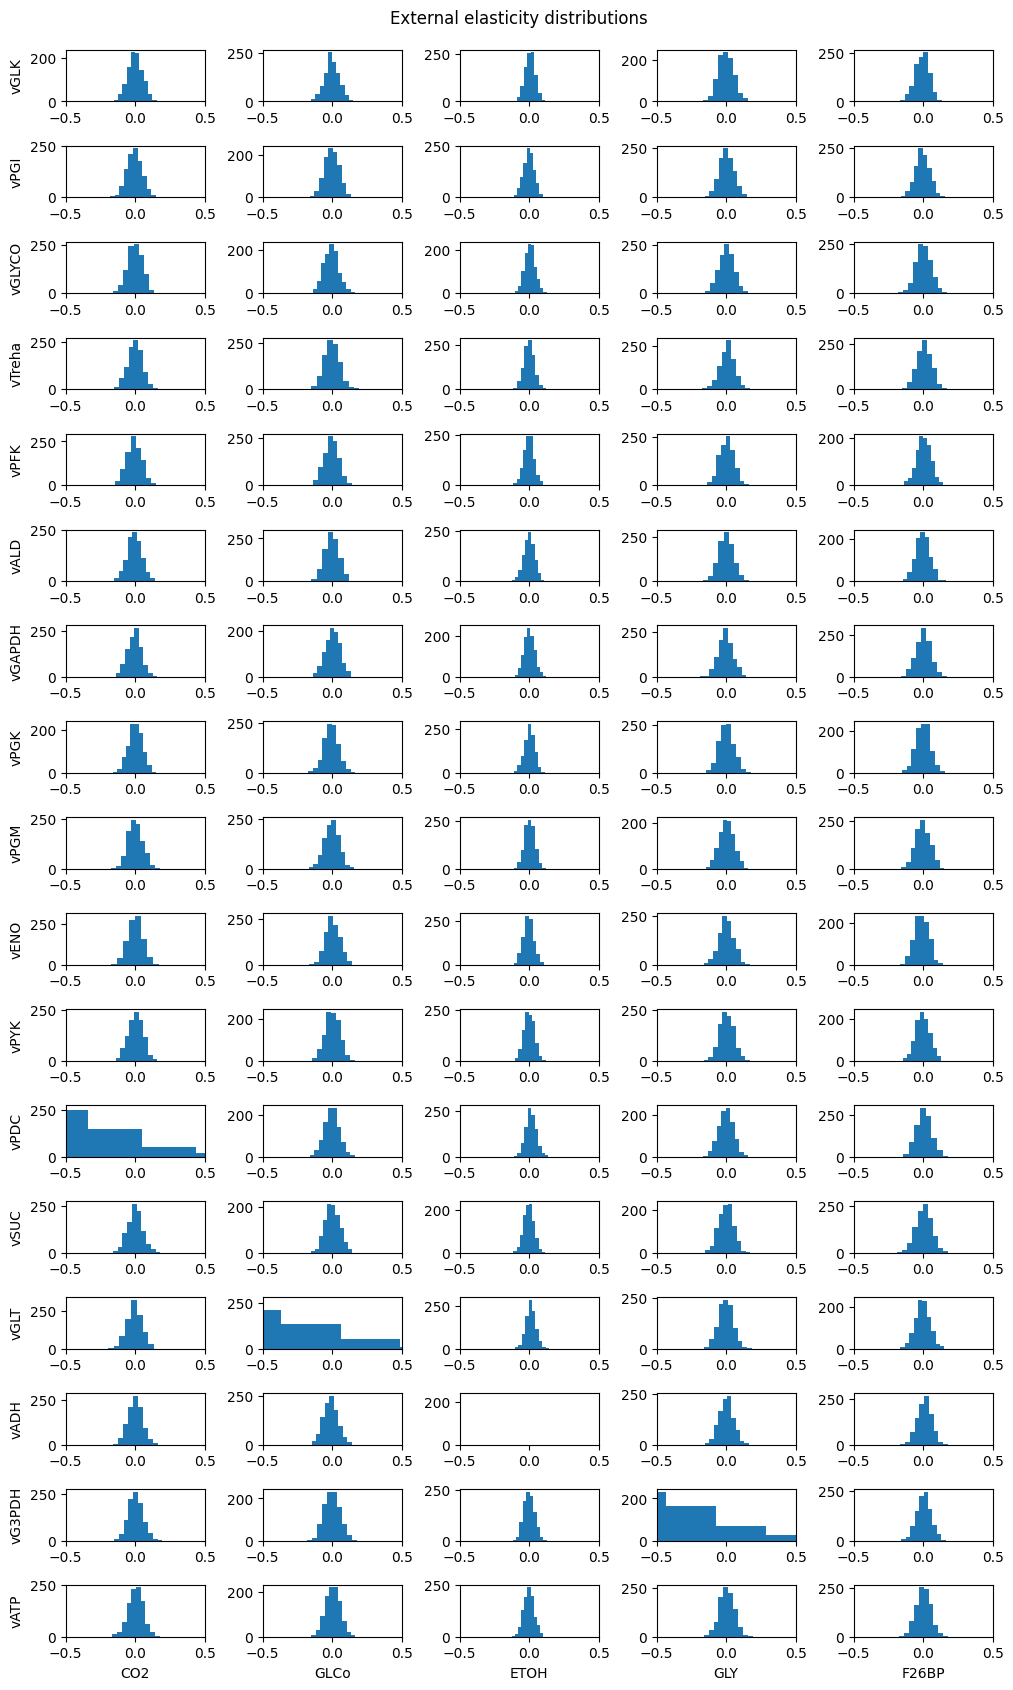

In [12]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,5, figsize=(10, 17)) 

fig.suptitle('External elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(5):
    axs[i,ii].hist(Ey_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getBoundarySpeciesIds()[ii])

In [13]:
Ey_peaks=[]

for i in range(Ey_trace.shape[0]):
    for ii in range(Ey_trace.shape[1]):
        Ey_peaks.append(np.percentile(Ey_trace[i,ii,:],50))


In [14]:
# elasticities from Bayesian inf posteriors

y = np.array(Ey_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
y[abs(y) < 0.01] = 0

y = y.reshape((17,5))
Ey = pd.DataFrame(y, index=r.getReactionIds(), columns=r.getBoundarySpeciesIds())
Ey

,CO2,GLCo,ETOH,GLY,F26BP
vGLK,0.000000,0.000000,0.000000,0.000000,0.000000
vPGI,0.000000,0.000000,0.000000,0.000000,0.000000
vGLYCO,0.000000,0.000000,0.000000,0.000000,0.000000
vTreha,0.000000,0.000000,0.000000,0.010448,0.000000
vPFK,0.000000,0.000000,0.000000,0.000000,0.000000
vALD,0.000000,0.000000,0.000000,0.000000,0.000000
vGAPDH,0.000000,0.000000,0.000000,0.000000,0.000000
vPGK,0.000000,0.000000,0.000000,0.000000,0.000000
vPGM,0.000000,0.000000,0.000000,0.000000,0.000000
vENO,0.000000,0.000000,0.000000,0.000000,-0.013113


In [15]:
a = data['ETOH']/50
a.drop(a.index[0],inplace=True)

In [16]:
# get the real values
real_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_values = real_values.div(real_values.iloc[0])
rel_real_values.drop(rel_real_values.index[0], inplace=True)
rel_real_values.columns = r.getReactionIds()
rel_real_values = rel_real_values.transpose()
rel_real_values.columns = a.round(2).values
rel_real_values


,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,1.013158,1.009094,1.006402,1.004547,1.003245,1.002322,1.001665,1.001195,1.000858,1.000617,1.000444,1.000319,1.000230,1.000165,1.0,0.999835,0.999771,0.999682,0.999558,0.999387,0.999149,0.998819,0.998363,0.997732,0.996860,0.995658,0.994002,0.991724,0.988587,0.984251
vPGI,1.014996,1.010364,1.007296,1.005182,1.003698,1.002646,1.001897,1.001362,1.000978,1.000703,1.000506,1.000364,1.000262,1.000188,1.0,0.999812,0.999739,0.999638,0.999497,0.999301,0.999030,0.998655,0.998135,0.997415,0.996422,0.995052,0.993165,0.990568,0.986993,0.982052
vGLYCO,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vTreha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vPFK,1.014996,1.010364,1.007296,1.005182,1.003698,1.002646,1.001897,1.001362,1.000978,1.000703,1.000506,1.000364,1.000262,1.000188,1.0,0.999812,0.999739,0.999638,0.999497,0.999301,0.999030,0.998655,0.998135,0.997415,0.996422,0.995052,0.993165,0.990568,0.986993,0.982052
vALD,1.014996,1.010364,1.007296,1.005182,1.003698,1.002646,1.001897,1.001362,1.000978,1.000703,1.000506,1.000364,1.000262,1.000188,1.0,0.999812,0.999739,0.999638,0.999497,0.999301,0.999030,0.998655,0.998135,0.997415,0.996422,0.995052,0.993165,0.990568,0.986993,0.982052
vGAPDH,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890
vPGK,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890
vPGM,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890
vENO,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890


In [17]:
# c_df is the flux calculated using the Bayesian inference PRIORS for elasticity
c = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + BIOMD64.Ex@(BIOMD64.xn).T + BIOMD64.Ey@(BIOMD64.yn).T)
c_df = pd.DataFrame(c) #, index=r.getReactionIds(), columns=a.round(2).values) 
c_df.index = r.getReactionIds()
c_df.columns = a.round(2).values
c_df = c_df.divide(c_df[1.00], axis=0)
c_df

,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,0.527154,0.712401,0.811909,0.872518,0.911809,0.938208,0.956345,0.968987,0.977883,0.984186,0.988671,0.991874,0.994165,0.995808,1.0,1.004156,1.005765,1.007992,1.011070,1.015315,1.021152,1.029148,1.040046,1.054798,1.074593,1.100856,1.135227,1.179500,1.235558,1.305404
vPGI,0.822680,0.884880,0.922265,0.946359,0.962485,0.973531,0.981214,0.986612,0.990432,0.993149,0.995087,0.996473,0.997466,0.998179,1.0,1.001809,1.002510,1.003482,1.004826,1.006682,1.009240,1.012755,1.017564,1.024106,1.032938,1.044741,1.060312,1.080516,1.106210,1.138118
vGLYCO,1.495558,1.301111,1.196813,1.133338,1.092214,1.064595,1.045627,1.032411,1.023111,1.016524,1.011837,1.008491,1.006096,1.004380,1.0,0.995658,0.993977,0.991651,0.988436,0.984004,0.977908,0.969560,0.958185,0.942792,0.922150,0.894784,0.859012,0.813024,0.754969,0.682987
vTreha,1.495558,1.301111,1.196813,1.133338,1.092214,1.064595,1.045627,1.032411,1.023111,1.016524,1.011837,1.008491,1.006096,1.004380,1.0,0.995658,0.993977,0.991651,0.988436,0.984004,0.977908,0.969560,0.958185,0.942792,0.922150,0.894784,0.859012,0.813024,0.754969,0.682987
vPFK,1.521604,1.331045,1.220366,1.150743,1.104846,1.073706,1.052185,1.037128,1.026503,1.018964,1.013592,1.009753,1.007004,1.005033,1.0,0.995006,0.993071,0.990392,0.986688,0.981577,0.974541,0.964890,0.951715,0.933843,0.909804,0.877818,0.835839,0.781664,0.713097,0.628140
vALD,1.064559,1.036710,1.023502,1.015788,1.010875,1.007602,1.005364,1.003808,1.002714,1.001940,1.001389,1.000997,1.000715,1.000514,1.0,0.999491,0.999293,0.999021,0.998643,0.998124,0.997409,0.996430,0.995096,0.993291,0.990868,0.987650,0.983427,0.977958,0.970964,0.962099
vGAPDH,0.947589,0.985627,0.996173,0.999595,1.000673,1.000910,1.000853,1.000711,1.000559,1.000424,1.000316,1.000234,1.000171,1.000125,1.0,0.999867,0.999815,0.999736,0.999626,0.999468,0.999233,0.998887,0.998361,0.997557,0.996319,0.994395,0.991418,0.986875,0.980107,0.970391
vPGK,1.354944,1.203564,1.128954,1.085674,1.058484,1.040606,1.028504,1.020157,1.014329,1.010224,1.007313,1.005238,1.003759,1.002699,1.0,0.997333,0.996301,0.994879,0.992915,0.990212,0.986513,0.981467,0.974645,0.965503,0.953403,0.937661,0.917609,0.892732,0.862860,0.828361
vPGM,0.957849,0.976317,0.985127,0.990161,0.993299,0.995354,0.996741,0.997696,0.998363,0.998832,0.999165,0.999402,0.999571,0.999692,1.0,1.000304,1.000422,1.000584,1.000809,1.001117,1.001539,1.002114,1.002891,1.003933,1.005311,1.007106,1.009395,1.012245,1.015694,1.019742
vENO,0.807727,0.887966,0.928470,0.952253,0.967305,0.977253,0.984009,0.988679,0.991946,0.994252,0.995887,0.997052,0.997885,0.998481,1.0,1.001502,1.002083,1.002886,1.003993,1.005518,1.007607,1.010459,1.014323,1.019513,1.026401,1.035404,1.046942,1.061376,1.078921,1.099550


Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

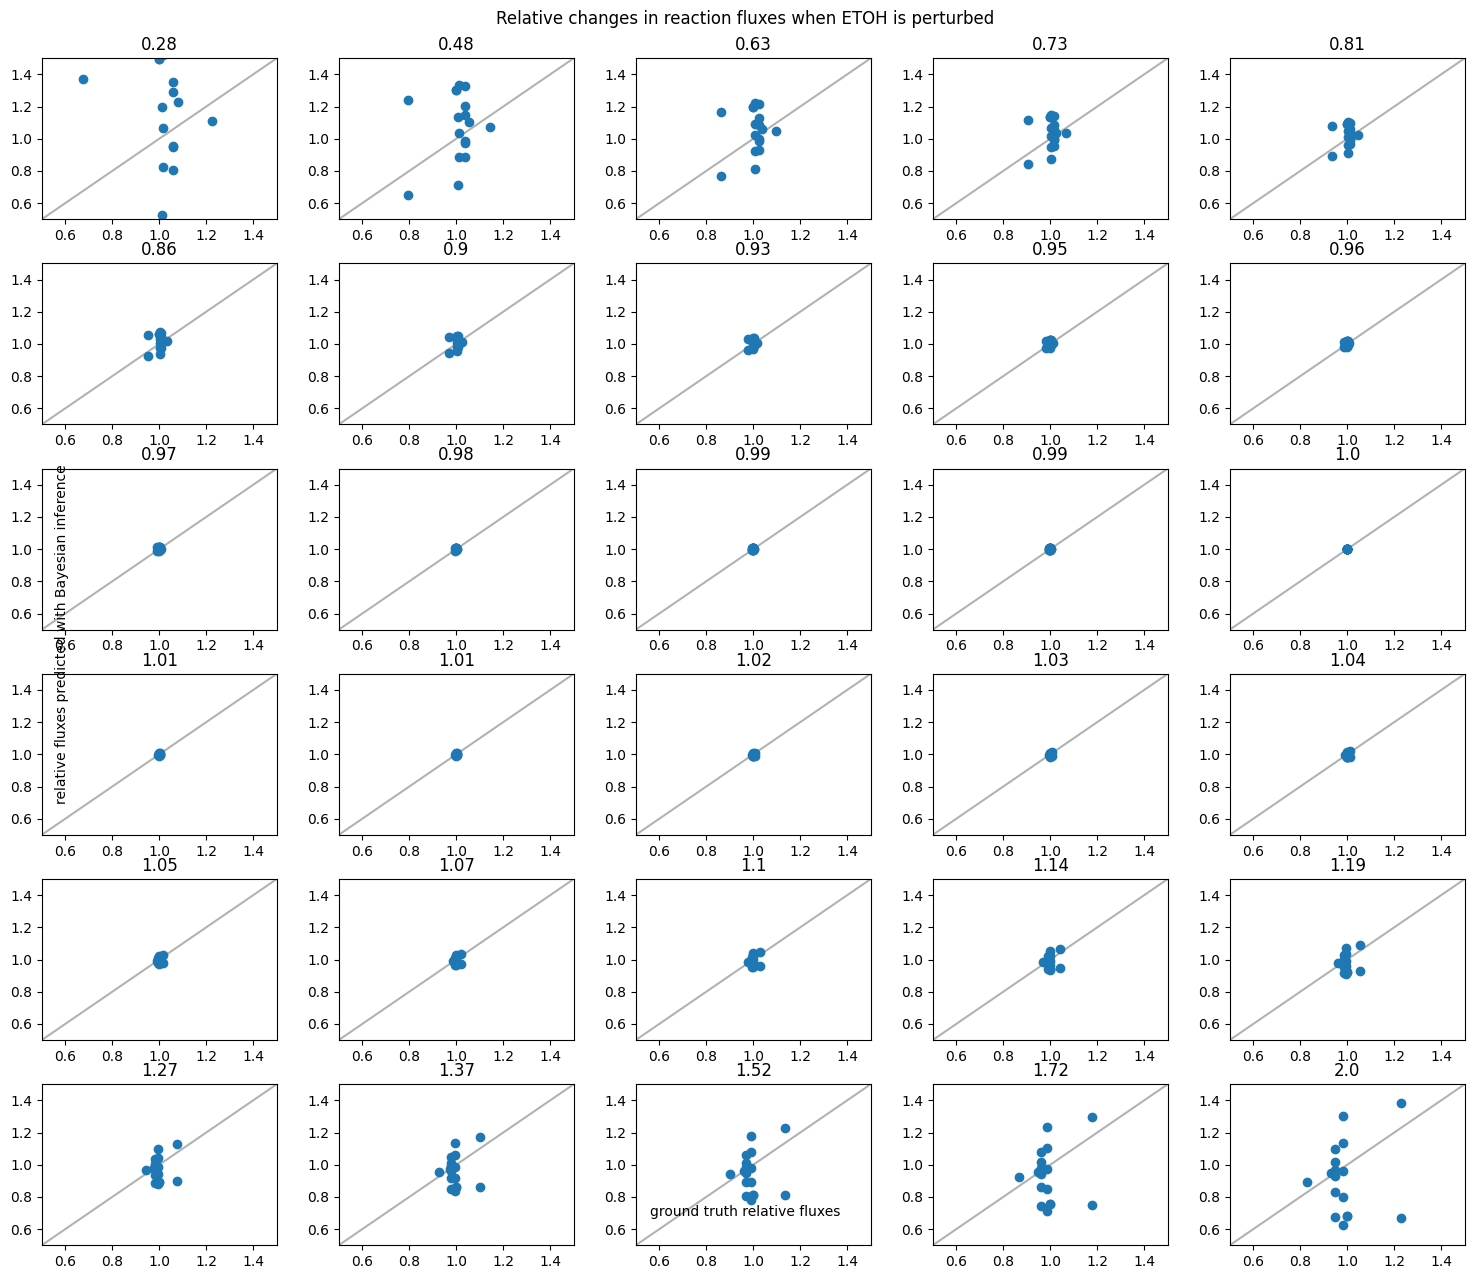

In [18]:
fig, axs = plt.subplots(6,5, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when ETOH is perturbed\n')
fig.tight_layout()

lims = [0.5,1.5]

for i,col in enumerate(c_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(rel_real_values[col], c_df[col])
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

In [19]:
# d_df is the flux calculated using the Bayesian inference POSTERIORS for elasticity
d = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + x@(BIOMD64.xn).T + y@(BIOMD64.yn).T)
d_df = pd.DataFrame(d) #, index=r.getReactionIds(), columns=a.round(2).values) 
d_df.index = r.getReactionIds()
d_df.columns = a.round(2).values
d_df = d_df.divide(d_df[1.00], axis=0)
d_df

,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,0.979884,0.991984,0.996431,0.998317,0.999178,0.999588,0.999790,0.999891,0.999943,0.999969,0.999983,0.999991,0.999995,0.999997,1.0,0.999999,0.999998,0.999996,0.999990,0.999980,0.999959,0.999918,0.999841,0.999697,0.999428,0.998940,0.998074,0.996578,0.994082,0.990077
vPGI,1.066027,1.026963,1.012916,1.006817,1.003856,1.002301,1.001433,1.000923,1.000611,1.000413,1.000284,1.000197,1.000139,1.000098,1.0,0.999911,0.999879,0.999836,0.999781,0.999713,0.999632,0.999547,0.999479,0.999471,0.999613,1.000061,1.001072,1.003034,1.006456,1.011895
vGLYCO,1.059221,1.039275,1.026970,1.018845,1.013300,1.009445,1.006736,1.004816,1.003451,1.002475,1.001777,1.001277,1.000918,1.000660,1.0,0.999343,0.999087,0.998733,0.998243,0.997564,0.996625,0.995330,0.993548,0.991103,0.987765,0.983231,0.977114,0.968926,0.958057,0.943739
vTreha,1.057621,1.037318,1.025299,1.017540,1.012317,1.008718,1.006202,1.004428,1.003169,1.002271,1.001630,1.001171,1.000841,1.000605,1.0,0.999398,0.999165,0.998841,0.998393,0.997773,0.996918,0.995739,0.994121,0.991908,0.988899,0.984834,0.979387,0.972158,0.962659,0.950289
vPFK,1.001477,1.013958,1.012654,1.009854,1.007346,1.005384,1.003915,1.002835,1.002048,1.001478,1.001065,1.000768,1.000553,1.000398,1.0,0.999601,0.999445,0.999228,0.998927,0.998507,0.997923,0.997108,0.995974,0.994394,0.992197,0.989154,0.984968,0.979272,0.971656,0.961722
vALD,1.028539,1.016377,1.010548,1.007115,1.004915,1.003442,1.002432,1.001728,1.001233,1.000882,1.000632,1.000453,1.000325,1.000234,1.0,0.999768,0.999678,0.999554,0.999382,0.999145,0.998819,0.998372,0.997762,0.996934,0.995819,0.994333,0.992371,0.989811,0.986503,0.982256
vGAPDH,1.046550,1.038899,1.028963,1.021042,1.015178,1.010921,1.007854,1.005649,1.004062,1.002921,1.002101,1.001512,1.001087,1.000782,1.0,0.999218,0.998915,0.998491,0.997904,0.997091,0.995961,0.994396,0.992229,0.989233,0.985108,0.979448,0.971735,0.961335,0.947508,0.929485
vPGK,1.073287,1.048413,1.031948,1.021560,1.014815,1.010318,1.007252,1.005130,1.003648,1.002604,1.001863,1.001334,1.000958,1.000688,1.0,0.999321,0.999057,0.998697,0.998197,0.997509,0.996569,0.995286,0.993557,0.991248,0.988208,0.984298,0.979418,0.973578,0.967026,0.960403
vPGM,1.060206,1.033912,1.021555,1.014411,1.009894,1.006901,1.004861,1.003447,1.002455,1.001754,1.001256,1.000900,1.000646,1.000464,1.0,0.999540,0.999362,0.999116,0.998777,0.998309,0.997666,0.996786,0.995590,0.993975,0.991815,0.988959,0.985237,0.980461,0.974432,0.966937
vENO,1.079565,1.041932,1.026056,1.017264,1.011809,1.008223,1.005789,1.004103,1.002922,1.002088,1.001495,1.001072,1.000769,1.000553,1.0,0.999453,0.999241,0.998948,0.998543,0.997986,0.997219,0.996170,0.994742,0.992809,0.990216,0.986766,0.982222,0.976293,0.968606,0.958653


Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

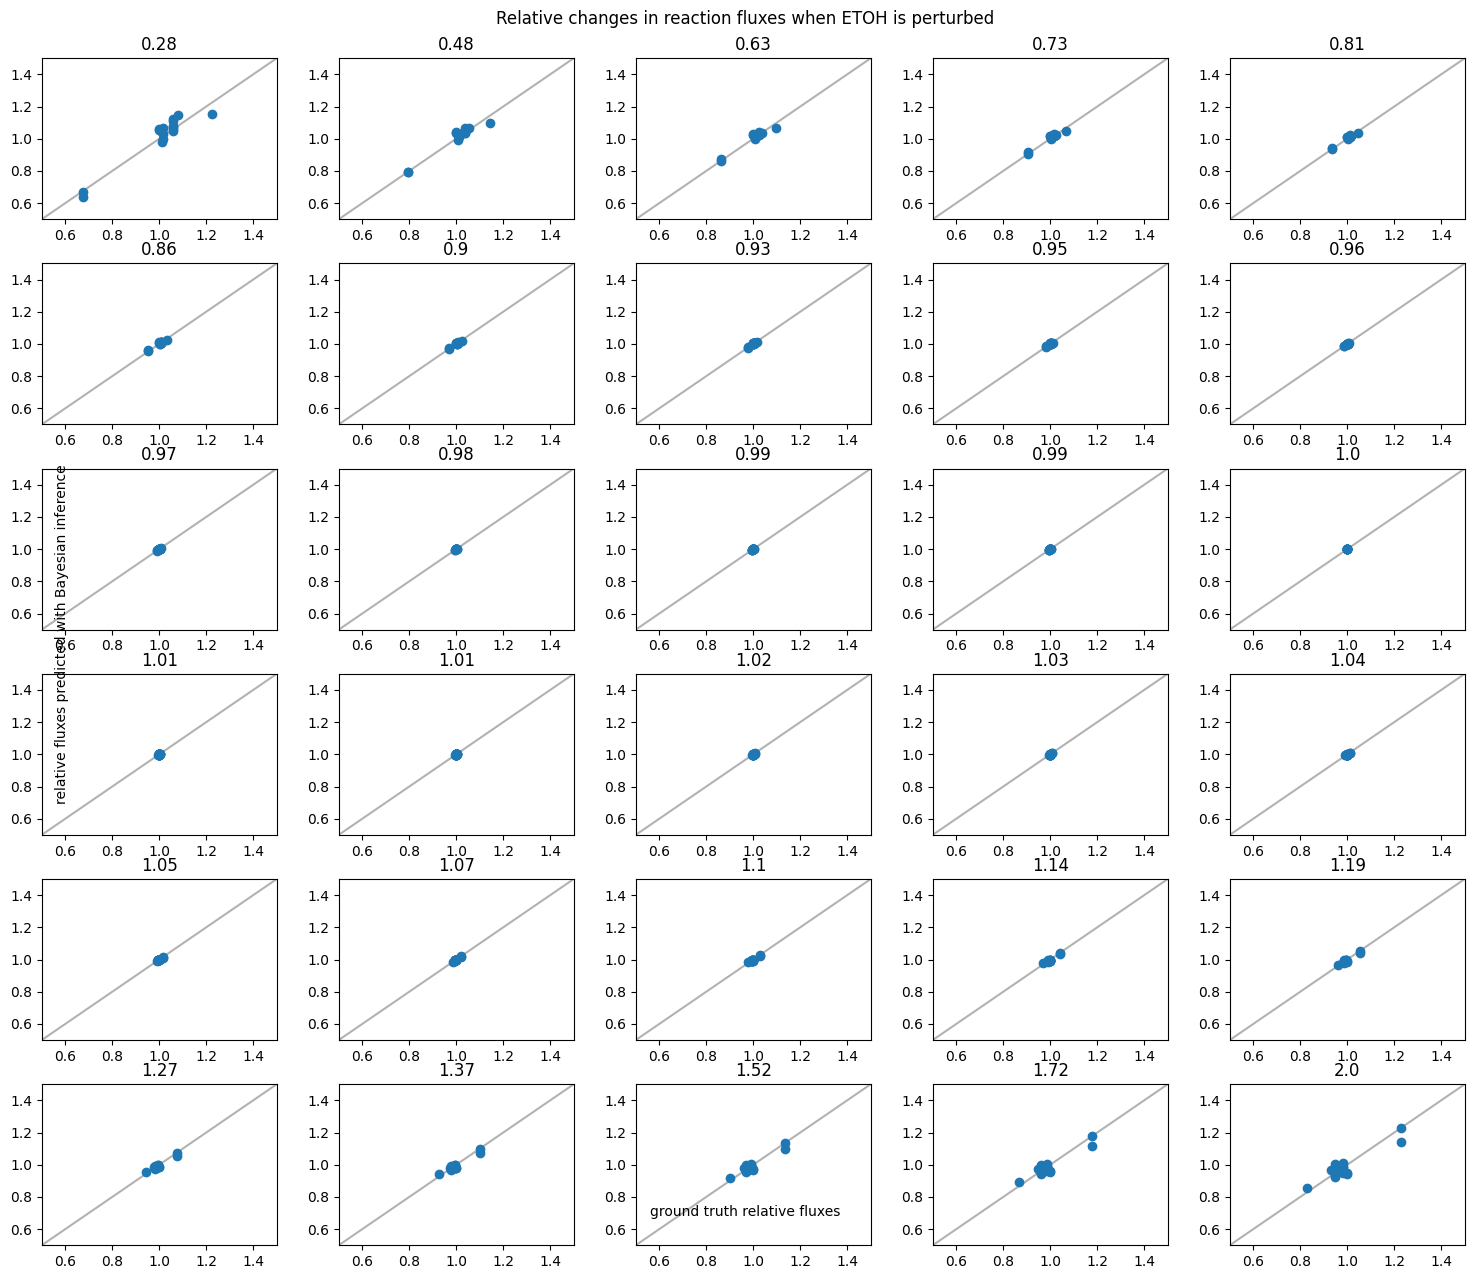

In [20]:
fig, axs = plt.subplots(6,5, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when ETOH is perturbed\n')
fig.tight_layout()

lims = [0.5,1.5]

for i,col in enumerate(d_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(rel_real_values[col], d_df[col])
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

Text(-9, 4, 'r = 0.518')

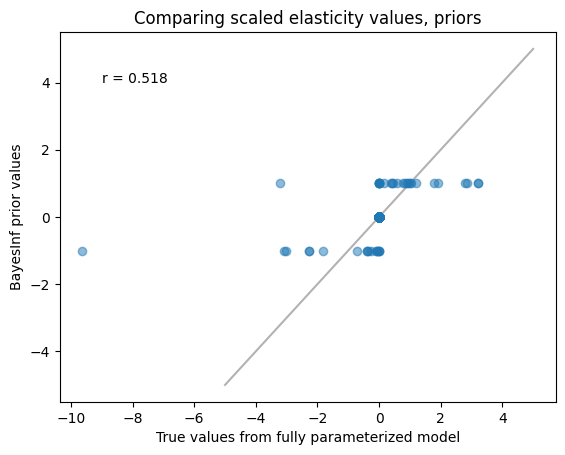

In [21]:
x # the posterior (bayes inf) elasticity values
BIOMD64.Ex # the prior elasticity values
Ex_values = r.getScaledElasticityMatrix()


fig = plt.figure()

plt.scatter(Ex_values, BIOMD64.Ex, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')

plt.text(-9,4,'r = ' + str((stats.pearsonr(Ex_values.flatten(), BIOMD64.Ex.to_numpy().flatten())[0]).round(3)))


Text(-9, 4, 'r = 0.54')

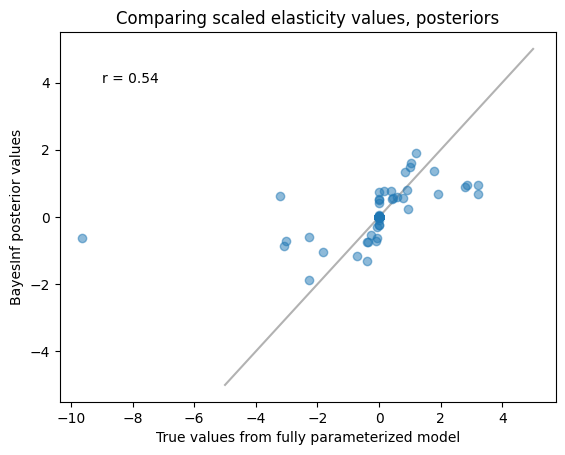

In [22]:
plt.scatter(Ex_values, x, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-9,4,'r = ' + str((stats.pearsonr(Ex_values.flatten(), x.flatten())[0]).round(3)))

# the dot all the way to the left is P on PGK

## Plotting MCC and FCC comparisons

In [23]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [24]:
visCCC, visFCC = util.elasticity_to_CCC(BIOMD64, BIOMD64.Ex)  
visCCC = pd.DataFrame(visCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
visFCC.columns = r.getReactionIds()
visFCC.index = r.getReactionIds()
visFCC

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH,vATP
vGLK,0.139587,0.079511,0.031414,0.028661,0.079511,0.079511,0.077840,0.077840,0.077840,0.077840,0.077840,0.077840,0.000836,0.139587,0.077004,0.001671,-0.124330
vPGI,0.082789,0.110380,-0.015836,-0.011755,0.110380,0.110380,0.075443,0.075443,0.075443,0.075443,0.075443,0.075443,0.017469,0.082789,0.057974,0.034937,-0.032161
vGLYCO,0.546373,-0.141574,0.814264,-0.126317,-0.141574,-0.141574,0.095007,0.095007,0.095007,0.095007,0.095007,0.095007,-0.118290,0.546373,0.213298,-0.236581,-0.784441
vTreha,0.546373,-0.141574,-0.185736,0.873683,-0.141574,-0.141574,0.095007,0.095007,0.095007,0.095007,0.095007,0.095007,-0.118290,0.546373,0.213298,-0.236581,-0.784441
vPFK,0.082789,0.110380,-0.015836,-0.011755,0.110380,0.110380,0.075443,0.075443,0.075443,0.075443,0.075443,0.075443,0.017469,0.082789,0.057974,0.034937,-0.032161
vALD,0.082789,0.110380,-0.015836,-0.011755,0.110380,0.110380,0.075443,0.075443,0.075443,0.075443,0.075443,0.075443,0.017469,0.082789,0.057974,0.034937,-0.032161
vGAPDH,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089
vPGK,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089
vPGM,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089
vENO,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089


In [25]:
postCCC, postFCC = util.elasticity_to_CCC(BIOMD64, Ex)  
postCCC = pd.DataFrame(postCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
postFCC = pd.DataFrame(postFCC) #, index=r.getReactionIds(), columns=r.getReactionIds())
postFCC.columns = r.getReactionIds()
postFCC.index = r.getReactionIds()
postFCC

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH,vATP
vGLK,0.107503,0.012243,0.035755,0.031039,0.061475,0.118058,0.085900,0.056642,0.121784,0.057074,0.073210,0.073303,-0.022692,0.188313,0.044091,0.042072,-0.085772
vPGI,0.109109,0.014382,-0.027466,-0.020565,0.072212,0.138969,0.090463,0.059650,0.128253,0.060040,0.077016,0.077115,-0.017522,0.191009,0.036416,0.060495,-0.049576
vGLYCO,0.051090,-0.000877,0.942798,-0.036224,-0.004405,-0.010393,0.063304,0.041742,0.089748,0.041613,0.053378,0.053455,-0.059667,0.088695,0.099210,-0.077534,-0.335931
vTreha,0.152144,-0.005815,-0.079277,0.946695,-0.029199,-0.058338,0.040616,0.026782,0.057583,0.028599,0.036684,0.036698,-0.059789,0.269384,0.098874,-0.105292,-0.356346
vPFK,0.109109,0.014382,-0.027466,-0.020565,0.072212,0.138969,0.090463,0.059650,0.128253,0.060040,0.077016,0.077115,-0.017522,0.191009,0.036416,0.060495,-0.049576
vALD,0.109109,0.014382,-0.027466,-0.020565,0.072212,0.138969,0.090463,0.059650,0.128253,0.060040,0.077016,0.077115,-0.017522,0.191009,0.036416,0.060495,-0.049576
vGAPDH,0.087229,0.011120,-0.016102,-0.012912,0.055835,0.106370,0.105143,0.069330,0.149065,0.069153,0.088705,0.088832,-0.048315,0.151540,0.085458,0.008493,0.001056
vPGK,0.087229,0.011120,-0.016102,-0.012912,0.055835,0.106370,0.105143,0.069330,0.149065,0.069153,0.088705,0.088832,-0.048315,0.151540,0.085458,0.008493,0.001056
vPGM,0.087229,0.011120,-0.016102,-0.012912,0.055835,0.106370,0.105143,0.069330,0.149065,0.069153,0.088705,0.088832,-0.048315,0.151540,0.085458,0.008493,0.001056
vENO,0.087229,0.011120,-0.016102,-0.012912,0.055835,0.106370,0.105143,0.069330,0.149065,0.069153,0.088705,0.088832,-0.048315,0.151540,0.085458,0.008493,0.001056


Text(-4, 4, 'r = 0.482')

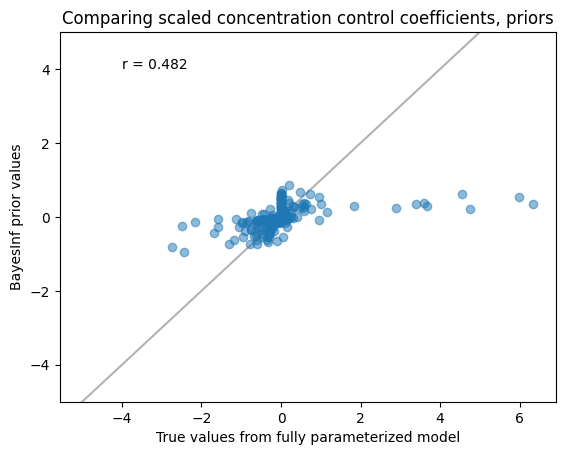

In [26]:
fig = plt.figure()

plt.scatter(gtCCC, visCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.ylim([-5,5])
plt.title('Comparing scaled concentration control coefficients, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), visCCC.to_numpy().flatten())[0]).round(3)))


Text(-4, 4, 'r = 0.67')

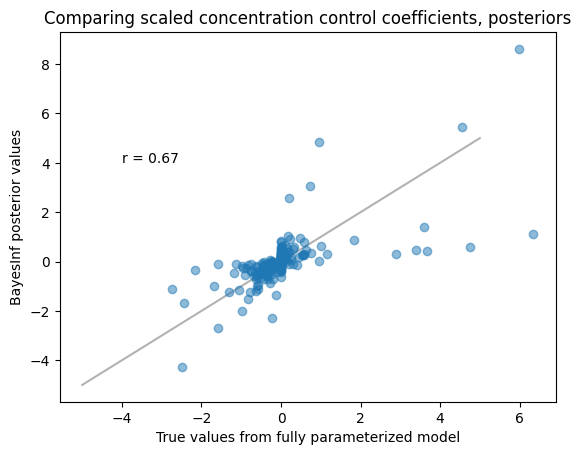

In [27]:
fig = plt.figure()

plt.scatter(gtCCC, postCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled concentration control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), postCCC.to_numpy().flatten())[0]).round(3)))

Text(-1, 2, 'r = 0.234')

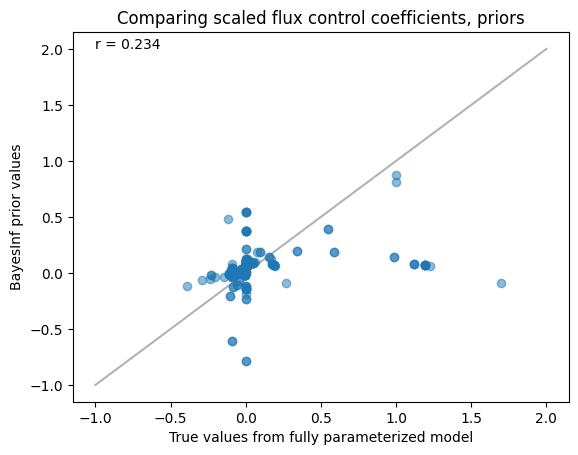

In [28]:
fig = plt.figure()

plt.scatter(gtFCC, visFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')
plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), visFCC.to_numpy().flatten())[0]).round(3)))

Text(-1, 2, 'r = 0.479')

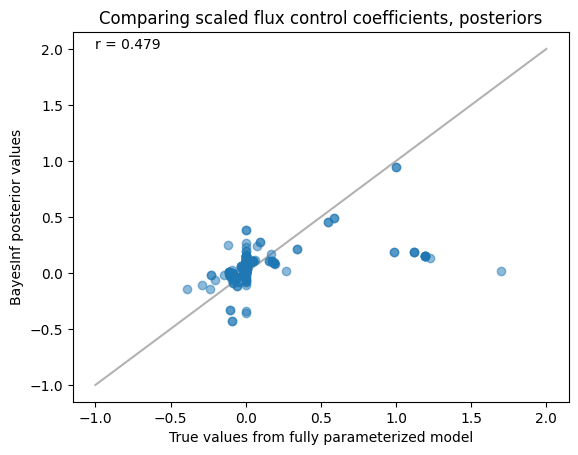

In [29]:
fig = plt.figure()

plt.scatter(gtFCC, postFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), postFCC.to_numpy().flatten())[0]).round(3)))

## Ranking FCC values

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



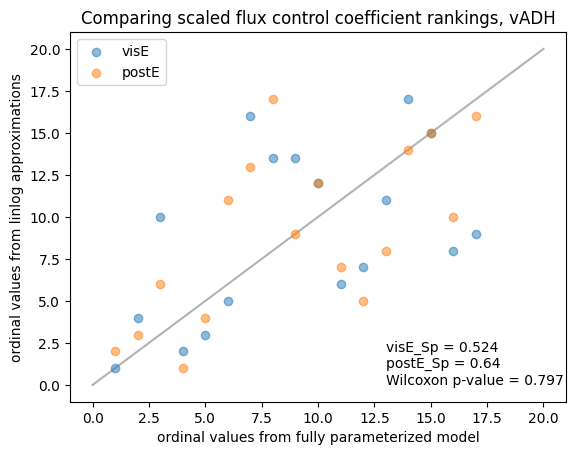

In [30]:
FCCrankings = pd.concat([gtFCC.loc['vADH'].rank(), visFCC.loc['vADH'].rank(), postFCC.loc['vADH'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings, vADH')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'Wilcoxon p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))
plt.legend()

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



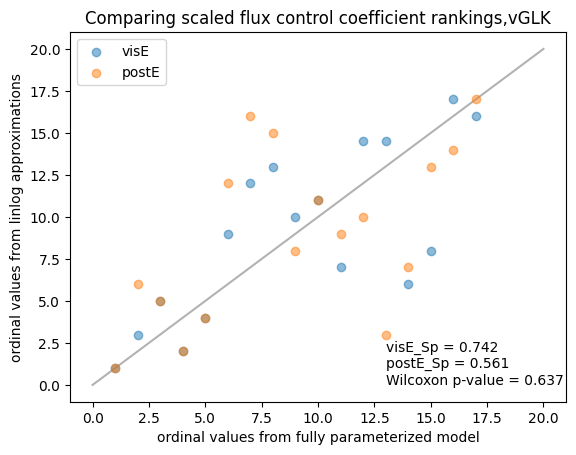

In [31]:
FCCrankings = pd.concat([gtFCC.loc['vGLK'].rank(), visFCC.loc['vGLK'].rank(), postFCC.loc['vGLK'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings,vGLK')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'Wilcoxon p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))

plt.legend()

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



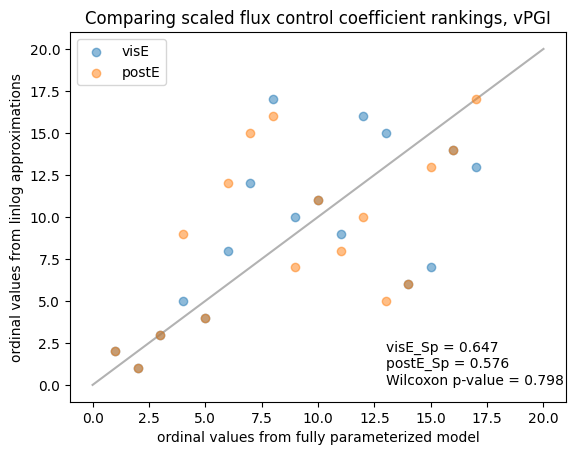

In [32]:
FCCrankings = pd.concat([gtFCC.loc['vPGI'].rank(), visFCC.loc['vPGI'].rank(), postFCC.loc['vPGI'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings, vPGI')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'Wilcoxon p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))

plt.legend()

## Distribution of FCC 

In [33]:
visE_r=[]
postE_r=[]

for i in r.getReactionIds():        
    FCCrankings = pd.concat([gtFCC.loc[i].rank(), visFCC.loc[i].rank(), postFCC.loc[i].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    visE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0])
    postE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0])


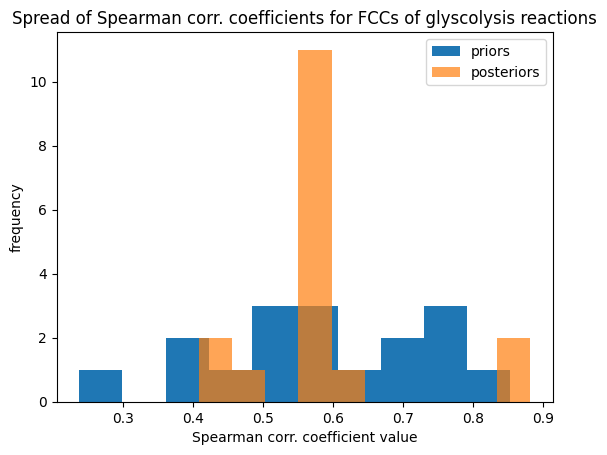

In [34]:
plt.hist(visE_r, label='priors')
plt.hist(postE_r, alpha=0.7, label='posteriors')
plt.legend()
plt.xlabel('Spearman corr. coefficient value')
plt.ylabel('frequency')
plt.title('Spread of Spearman corr. coefficients for FCCs of glyscolysis reactions')

plt.show()


# Perturbing enzymes

In [35]:
pt_levels= np.logspace(-1, 0, num=20)
pt_levels = pt_levels.round(3)
pt_levels

array([0.1  , 0.113, 0.127, 0.144, 0.162, 0.183, 0.207, 0.234, 0.264,
       0.298, 0.336, 0.379, 0.428, 0.483, 0.546, 0.616, 0.695, 0.785,
       0.886, 1.   ])

In [37]:
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/enzymeCompilation.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

5.935978122618177e-12

In [38]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

In [39]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [40]:
with pymc_model:
    
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BIOMD64.en.T)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BIOMD64.xn.T)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BIOMD64.yn.T)


In [41]:
with pymc_model:
    
    likelihood = pm.Deterministic('vn', e_obs * (np.ones((17,641)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)

pymc_model.free_RVs

[Ex_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ex_capacity_entries ~ Laplace(0, 0.01),
 Ey_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ey_capacity_entries ~ Laplace(0, 0.01)]

In [42]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=       N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)
    

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.4318e+05
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


In [43]:
# takig the median peaks can only be done if the distributions are unimodal!
Ex_trace = (trace_vi['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_trace.shape

(17, 14, 1000)

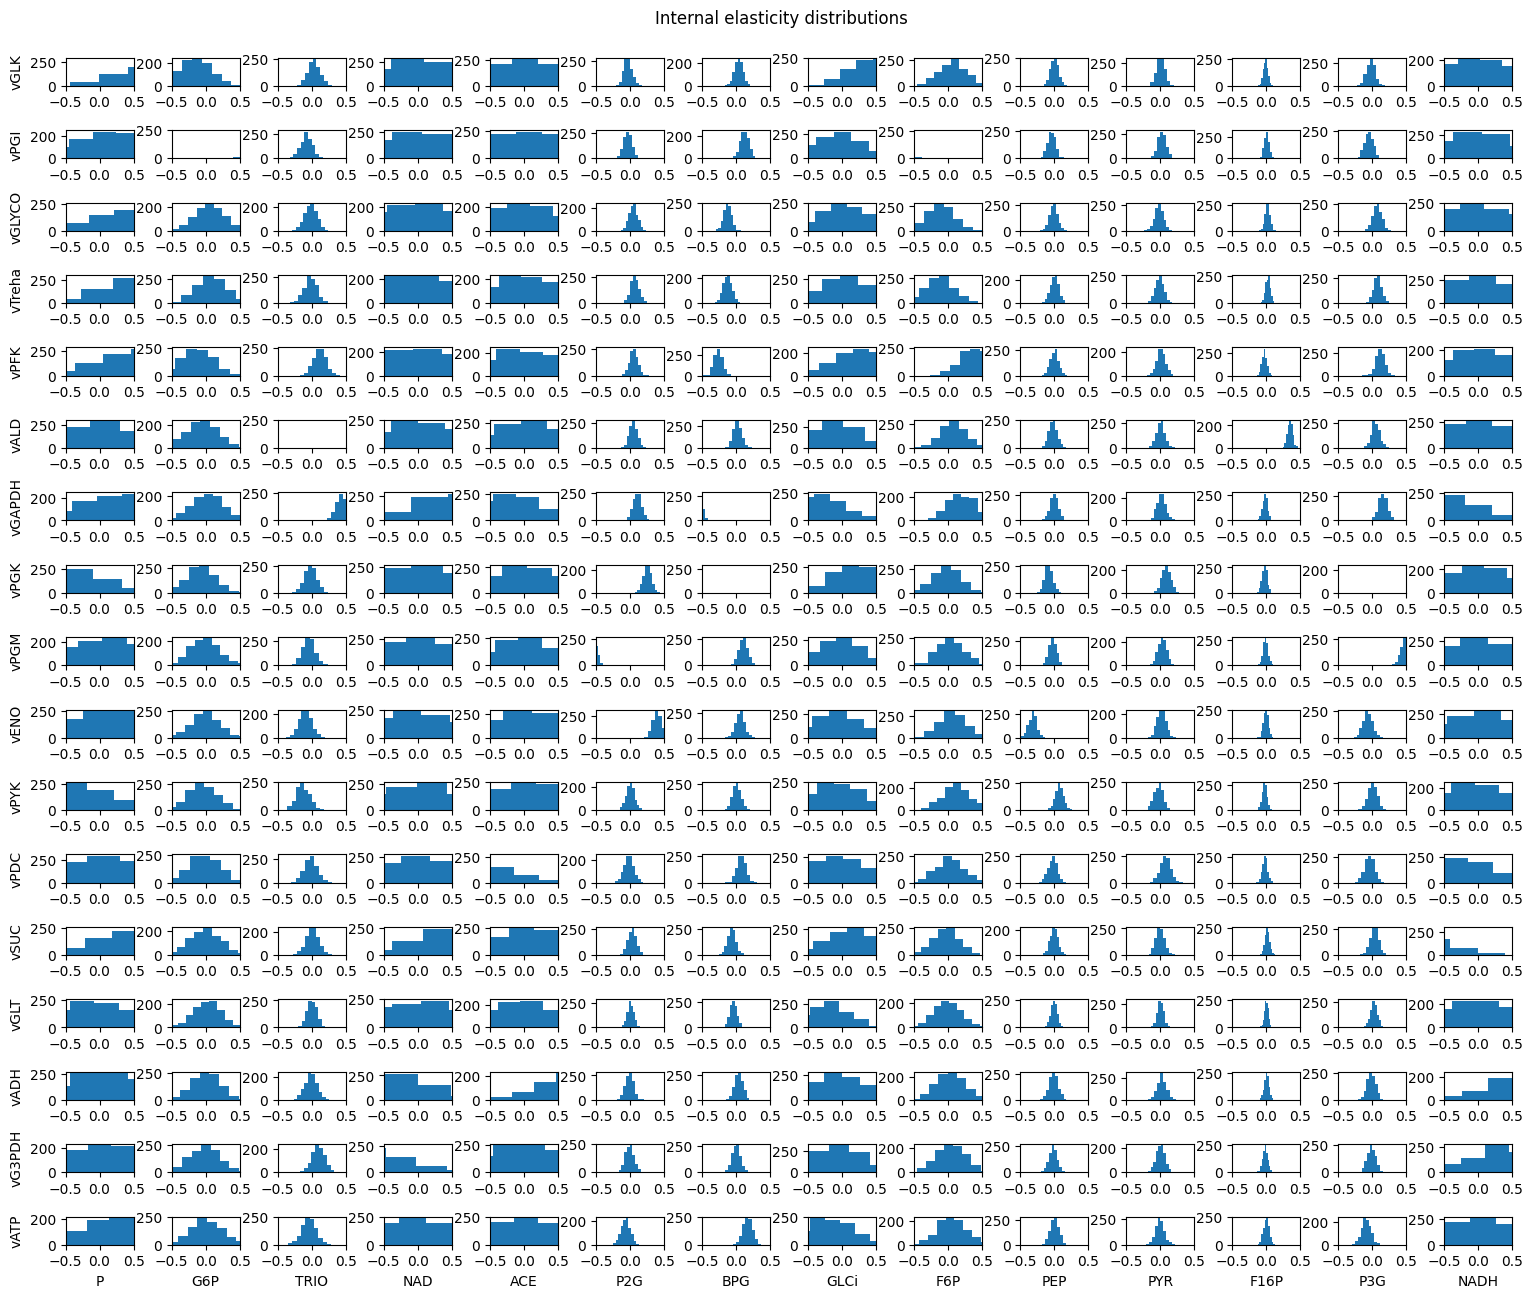

In [44]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(14):
    axs[i,ii].hist(Ex_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

In [45]:
Ex_peaks=[]

for i in range(Ex_trace.shape[0]):
    for ii in range(Ex_trace.shape[1]):
        Ex_peaks.append(np.percentile(Ex_trace[i,ii,:],50))


In [46]:
# these are the elasticity posteriors from Bayesian inference
x = np.array(Ex_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
x[abs(x) < 0.01] = 0

x = x.reshape((17,14))
Ex = pd.DataFrame(x, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())
Ex

,P,G6P,TRIO,NAD,ACE,P2G,BPG,GLCi,F6P,PEP,PYR,F16P,P3G,NADH
vGLK,1.010570,-0.151892,0.032459,0.000000,0.016912,-0.029778,0.043943,0.485920,0.067970,0.000000,0.000000,0.000000,-0.020747,0.000000
vPGI,0.181011,1.213253,-0.072133,-0.011341,0.035234,-0.029337,0.124355,-0.059982,-0.980369,-0.038734,0.024070,0.000000,-0.051289,-0.048038
vGLYCO,0.662317,0.067803,-0.010035,-0.010504,-0.034727,0.051919,-0.120354,0.018483,-0.108944,0.000000,-0.015771,0.019600,0.070320,0.000000
vTreha,0.675493,0.082963,-0.015632,0.000000,-0.017288,0.071511,-0.123350,0.000000,-0.124744,0.000000,0.000000,0.022763,0.076242,-0.010697
vPFK,0.604272,-0.127971,0.120914,0.032174,-0.038097,0.054575,-0.259529,0.282176,0.398845,0.000000,0.012073,-0.028319,0.119083,0.000000
vALD,0.026562,-0.050575,-0.984839,0.038089,0.038398,0.053732,0.020008,-0.102283,0.071920,-0.015153,0.000000,0.350069,0.045154,0.000000
vGAPDH,0.336389,0.031811,0.457705,0.742306,-0.254788,0.110461,-0.570730,-0.350738,0.189534,0.000000,0.014863,-0.017314,0.158107,-0.683667
vPGK,-0.591852,-0.080304,-0.017385,-0.018654,0.052982,0.255227,0.690541,0.182639,-0.020787,-0.079034,0.088543,-0.022881,-0.896168,0.000000
vPGM,0.087747,-0.019398,-0.037553,0.000000,0.017162,-0.551476,0.108613,-0.044612,0.032261,-0.020000,0.031039,-0.011705,0.486375,0.000000
vENO,0.100962,0.000000,-0.091742,-0.010884,0.054034,0.399968,0.059368,-0.078939,0.067266,-0.311510,0.019909,0.000000,-0.067534,0.024702


In [47]:
Ey_trace = (trace_vi['posterior']['Ey']).to_numpy().squeeze().transpose(1, 2, 0)
Ey_trace.shape

(17, 5, 1000)

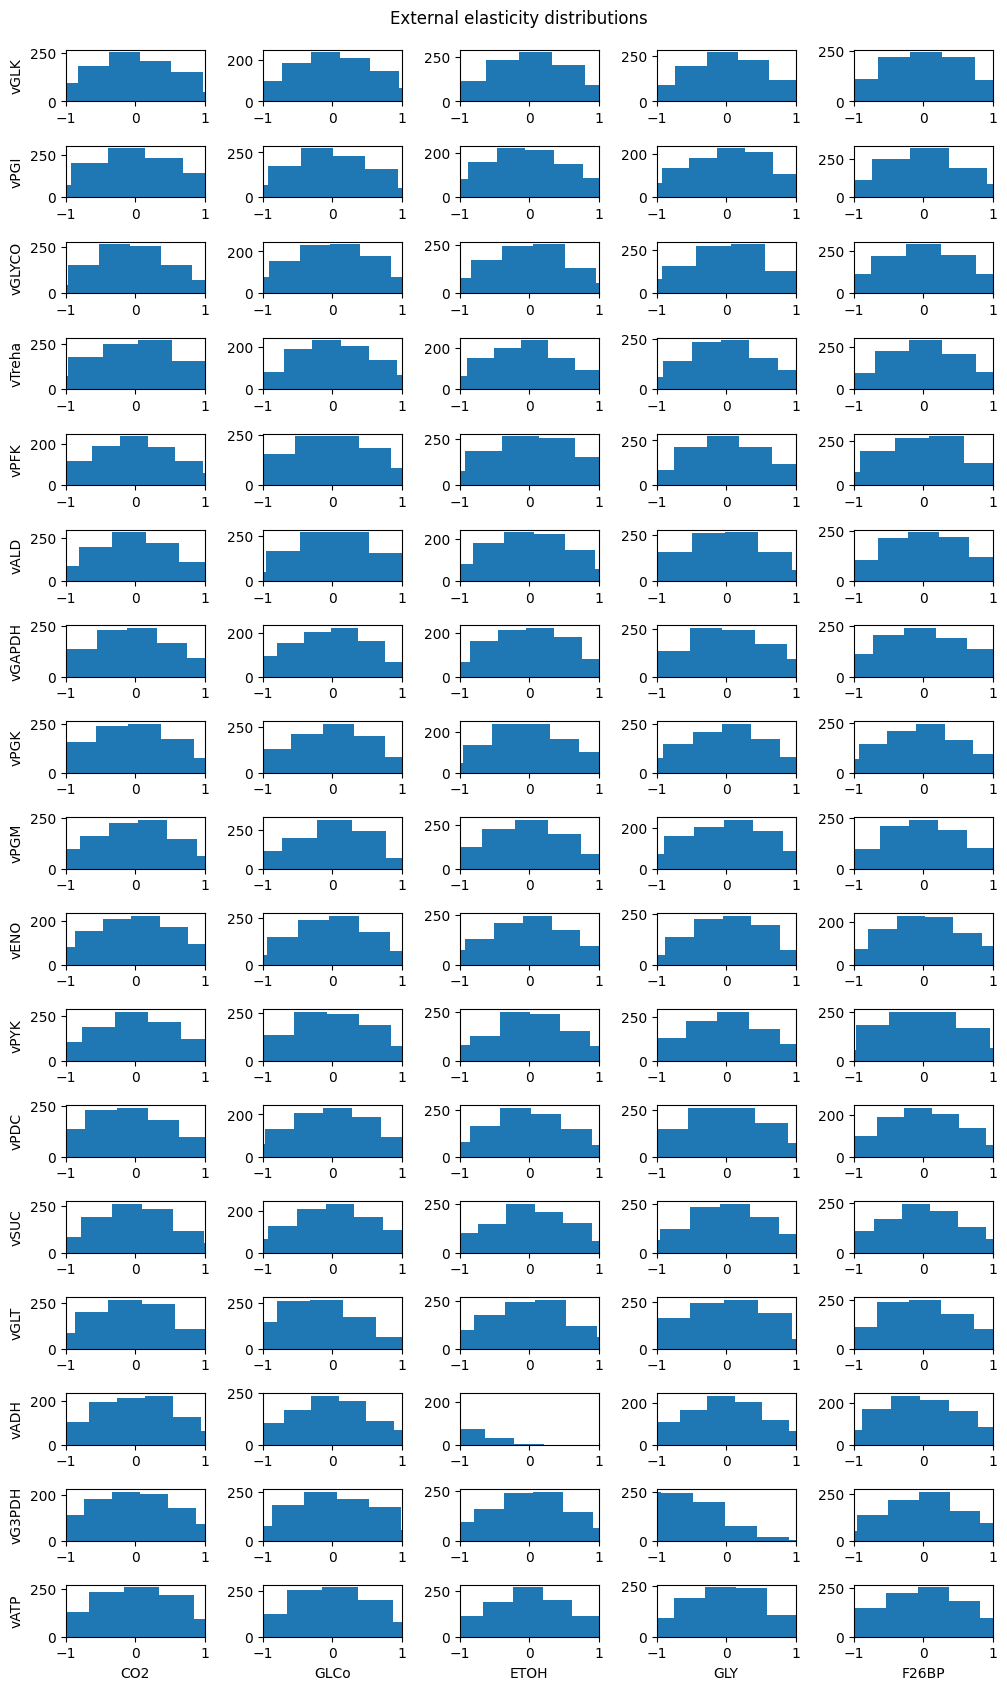

In [48]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,5, figsize=(10, 17)) 

fig.suptitle('External elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(5):
    axs[i,ii].hist(Ey_trace[i,ii,:])
    axs[i,ii].set_xlim([-1,1])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getBoundarySpeciesIds()[ii])

In [49]:
Ey_peaks=[]

for i in range(Ey_trace.shape[0]):
    for ii in range(Ey_trace.shape[1]):
        Ey_peaks.append(np.percentile(Ey_trace[i,ii,:],50))


In [50]:
# elasticities from Bayesian inf posteriors

y = np.array(Ey_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
y[abs(y) < 0.01] = 0

y = y.reshape((17,5))
Ey = pd.DataFrame(y, index=r.getReactionIds(), columns=r.getBoundarySpeciesIds())
Ey

,CO2,GLCo,ETOH,GLY,F26BP
vGLK,-0.029989,0.000000,0.032047,0.025128,0.027745
vPGI,0.000000,-0.056348,-0.052186,0.049591,0.000000
vGLYCO,-0.052857,-0.010078,0.000000,0.023016,0.000000
vTreha,0.000000,0.016732,-0.022550,-0.017766,0.019491
vPFK,0.000000,0.000000,0.039089,0.000000,0.016448
vALD,-0.028354,0.024641,0.000000,0.000000,0.000000
vGAPDH,-0.016083,0.000000,-0.012287,0.014256,0.000000
vPGK,-0.023576,0.039668,-0.023427,0.000000,-0.024658
vPGM,0.000000,0.000000,-0.047608,0.034185,0.000000
vENO,0.000000,0.013618,0.019729,0.074407,0.013195


In [51]:
enzymes = [i for i in data.columns if 'e_' in i]

In [52]:
a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:]]

a = data[data[enzymes] != 1].values.flatten()
pt_lvls = a[~np.isnan(a)]

C:\Users\user\AppData\Local\Temp\ipykernel_23988\1020810182.py:2: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [53]:
# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]

In [54]:
# get the real values
real_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_values = real_values.div(real_values.iloc[0])
rel_real_values.drop(rel_real_values.index[0], inplace=True)
rel_real_values.columns = r.getReactionIds()
rel_real_values = rel_real_values.transpose()
rel_real_values.columns = enzPtLvls
rel_real_values

,e_vGLK|0.9,e_vGLK|1.1,e_vPGI|0.9,e_vPGI|1.1,e_vGLYCO|0.9,e_vGLYCO|1.1,e_vTreha|0.9,e_vTreha|1.1,e_vPFK|0.9,e_vPFK|1.1,e_vALD|0.9,e_vALD|1.1,e_vGAPDH|0.9,e_vGAPDH|1.1,e_vPGK|0.9,e_vPGK|1.1,e_vPGM|0.9,e_vPGM|1.1,e_vENO|0.9,e_vENO|1.1,e_vPYK|0.9,e_vPYK|1.1,e_vPDC|0.9,e_vPDC|1.1,e_vSUC|0.9,e_vSUC|1.1,e_vGLT|0.9,e_vGLT|1.1,e_vADH|0.9,e_vADH|1.1,e_vG3PDH|0.9,e_vG3PDH|1.1,e_vATP|0.9,e_vATP|1.1,e_vGLK|0.887,e_vGLK|1.113,e_vPGI|0.887,e_vPGI|1.113,e_vGLYCO|0.887,e_vGLYCO|1.113,e_vTreha|0.887,e_vTreha|1.113,e_vPFK|0.887,e_vPFK|1.113,e_vALD|0.887,e_vALD|1.113,e_vGAPDH|0.887,e_vGAPDH|1.113,e_vPGK|0.887,e_vPGK|1.113,e_vPGM|0.887,e_vPGM|1.113,e_vENO|0.887,e_vENO|1.113,e_vPYK|0.887,e_vPYK|1.113,e_vPDC|0.887,e_vPDC|1.113,e_vSUC|0.887,e_vSUC|1.113,e_vGLT|0.887,e_vGLT|1.113,e_vADH|0.887,e_vADH|1.113,e_vG3PDH|0.887,e_vG3PDH|1.113,e_vATP|0.887,e_vATP|1.113,e_vGLK|0.873,e_vGLK|1.127,e_vPGI|0.873,e_vPGI|1.127,e_vGLYCO|0.873,e_vGLYCO|1.127,e_vTreha|0.873,e_vTreha|1.127,e_vPFK|0.873,e_vPFK|1.127,e_vALD|0.873,e_vALD|1.127,e_vGAPDH|0.873,e_vGAPDH|1.127,e_vPGK|0.873,e_vPGK|1.127,e_vPGM|0.873,e_vPGM|1.127,e_vENO|0.873,e_vENO|1.127,e_vPYK|0.873,e_vPYK|1.127,e_vPDC|0.873,e_vPDC|1.127,e_vSUC|0.873,e_vSUC|1.127,e_vGLT|0.873,e_vGLT|1.127,e_vADH|0.873,e_vADH|1.127,e_vG3PDH|0.873,e_vG3PDH|1.127,e_vATP|0.873,e_vATP|1.127,e_vGLK|0.856,e_vGLK|1.144,e_vPGI|0.856,e_vPGI|1.144,e_vGLYCO|0.856,e_vGLYCO|1.144,e_vTreha|0.856,e_vTreha|1.144,e_vPFK|0.856,e_vPFK|1.144,e_vALD|0.856,e_vALD|1.144,e_vGAPDH|0.856,e_vGAPDH|1.144,e_vPGK|0.856,e_vPGK|1.144,e_vPGM|0.856,e_vPGM|1.144,e_vENO|0.856,e_vENO|1.144,e_vPYK|0.856,e_vPYK|1.144,e_vPDC|0.856,e_vPDC|1.144,e_vSUC|0.856,e_vSUC|1.144,e_vGLT|0.856,e_vGLT|1.144,e_vADH|0.856,e_vADH|1.144,e_vG3PDH|0.856,e_vG3PDH|1.144,e_vATP|0.856,e_vATP|1.144,e_vGLK|0.838,e_vGLK|1.162,e_vPGI|0.838,e_vPGI|1.162,e_vGLYCO|0.838,e_vGLYCO|1.162,e_vTreha|0.838,e_vTreha|1.162,e_vPFK|0.838,e_vPFK|1.162,e_vALD|0.838,e_vALD|1.162,e_vGAPDH|0.838,e_vGAPDH|1.162,e_vPGK|0.838,e_vPGK|1.162,e_vPGM|0.838,e_vPGM|1.162,e_vENO|0.838,e_vENO|1.162,e_vPYK|0.838,e_vPYK|1.162,e_vPDC|0.838,e_vPDC|1.162,e_vSUC|0.838,e_vSUC|1.162,e_vGLT|0.838,e_vGLT|1.162,e_vADH|0.838,e_vADH|1.162,e_vG3PDH|0.838,e_vG3PDH|1.162,e_vATP|0.838,e_vATP|1.162,e_vGLK|0.817,e_vGLK|1.183,e_vPGI|0.817,e_vPGI|1.183,e_vGLYCO|0.817,e_vGLYCO|1.183,e_vTreha|0.817,e_vTreha|1.183,e_vPFK|0.817,e_vPFK|1.183,e_vALD|0.817,e_vALD|1.183,e_vGAPDH|0.817,e_vGAPDH|1.183,e_vPGK|0.817,e_vPGK|1.183,e_vPGM|0.817,e_vPGM|1.183,e_vENO|0.817,e_vENO|1.183,e_vPYK|0.817,e_vPYK|1.183,e_vPDC|0.817,e_vPDC|1.183,e_vSUC|0.817,e_vSUC|1.183,e_vGLT|0.817,e_vGLT|1.183,e_vADH|0.817,e_vADH|1.183,e_vG3PDH|0.817,e_vG3PDH|1.183,e_vATP|0.817,e_vATP|1.183,e_vGLK|0.793,e_vGLK|1.207,e_vPGI|0.793,e_vPGI|1.207,e_vGLYCO|0.793,e_vGLYCO|1.207,e_vTreha|0.793,e_vTreha|1.207,e_vPFK|0.793,e_vPFK|1.207,e_vALD|0.793,e_vALD|1.207,e_vGAPDH|0.793,e_vGAPDH|1.207,e_vPGK|0.793,e_vPGK|1.207,e_vPGM|0.793,e_vPGM|1.207,e_vENO|0.793,e_vENO|1.207,e_vPYK|0.793,e_vPYK|1.207,e_vPDC|0.793,e_vPDC|1.207,e_vSUC|0.793,e_vSUC|1.207,e_vGLT|0.793,e_vGLT|1.207,e_vADH|0.793,e_vADH|1.207,e_vG3PDH|0.793,e_vG3PDH|1.207,e_vATP|0.793,e_vATP|1.207,e_vGLK|0.766,e_vGLK|1.234,e_vPGI|0.766,e_vPGI|1.234,e_vGLYCO|0.766,e_vGLYCO|1.234,e_vTreha|0.766,e_vTreha|1.234,e_vPFK|0.766,e_vPFK|1.234,e_vALD|0.766,e_vALD|1.234,e_vGAPDH|0.766,e_vGAPDH|1.234,e_vPGK|0.766,e_vPGK|1.234,e_vPGM|0.766,e_vPGM|1.234,e_vENO|0.766,e_vENO|1.234,e_vPYK|0.766,e_vPYK|1.234,e_vPDC|0.766,e_vPDC|1.234,e_vSUC|0.766,e_vSUC|1.234,e_vGLT|0.766,e_vGLT|1.234,e_vADH|0.766,e_vADH|1.234,e_vG3PDH|0.766,e_vG3PDH|1.234,e_vATP|0.766,e_vATP|1.234,e_vGLK|0.736,e_vGLK|1.264,e_vPGI|0.736,e_vPGI|1.264,e_vGLYCO|0.736,e_vGLYCO|1.264,e_vTreha|0.736,e_vTreha|1.264,e_vPFK|0.736,e_vPFK|1.264,e_vALD|0.736,e_vALD|1.264,e_vGAPDH|0.736,e_vGAPDH|1.264,e_vPGK|0.736,e_vPGK|1.264,e_vPGM|0.736,e_vPGM|1.264,e_vENO|0.736,e_vENO|1.264,e_vPYK|0.736,e_vPYK|1.264,e_vPDC|0.736,e_vPDC|1.264,e_vSUC|0.736,e_vSUC|1.264,e_vGLT|0.736,e_vGLT|1.264,e_vADH|0.736,e_vADH|1.264,e

Text(-9, 4, 'r = 0.491')

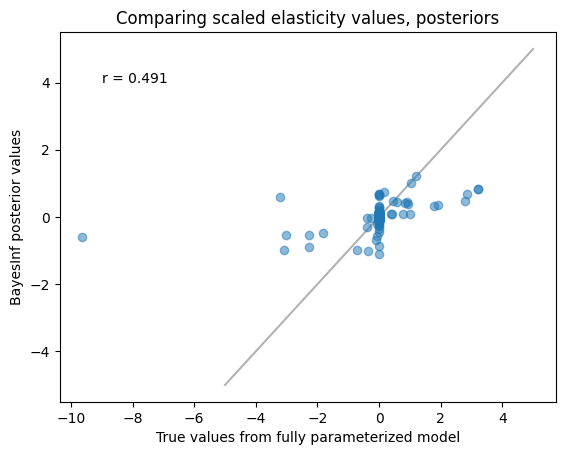

In [55]:
plt.scatter(Ex_values, x, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-9,4,'r = ' + str((stats.pearsonr(Ex_values.flatten(), x.flatten())[0]).round(3)))

# the dot all the way to the left is P on PGK

## Plotting MCC and FCC comparisons

In [56]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [57]:
postCCC, postFCC = util.elasticity_to_CCC(BIOMD64, Ex)  
postCCC = pd.DataFrame(postCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
postFCC = pd.DataFrame(postFCC) #, index=r.getReactionIds(), columns=r.getReactionIds())
postFCC.columns = r.getReactionIds()
postFCC.index = r.getReactionIds()
postFCC

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH,vATP
vGLK,0.338550,0.045567,0.120855,0.097565,-0.453093,0.070023,0.467803,0.095307,0.203143,0.144547,0.831858,0.006147,-0.130255,-1.178783,0.022562,0.349215,-0.031011
vPGI,0.418637,0.056143,0.046011,0.037359,-0.493628,0.073805,0.478991,0.057457,0.169223,0.153555,0.834851,0.038671,-0.124954,-1.135042,0.053433,0.354872,-0.019383
vGLYCO,-0.291755,-0.024146,1.173890,0.140757,-0.329593,0.066304,0.556549,0.369289,0.494726,0.127797,1.071948,-0.120931,-0.154143,-2.383816,-0.076375,0.437444,-0.057946
vTreha,-0.164130,-0.037719,0.010633,1.013751,0.045733,0.013718,0.176576,0.362775,0.385263,0.020334,0.483515,-0.359109,-0.185807,-0.377340,-0.351238,0.147767,-0.184723
vPFK,0.418637,0.056143,0.046011,0.037359,-0.493628,0.073805,0.478991,0.057457,0.169223,0.153555,0.834851,0.038671,-0.124954,-1.135042,0.053433,0.354872,-0.019383
vALD,0.418637,0.056143,0.046011,0.037359,-0.493628,0.073805,0.478991,0.057457,0.169223,0.153555,0.834851,0.038671,-0.124954,-1.135042,0.053433,0.354872,-0.019383
vGAPDH,0.467410,0.063283,0.066801,0.053088,-0.572655,0.082855,0.571135,0.066902,0.199514,0.181541,0.967535,0.041826,-0.179703,-1.422898,0.063978,0.336961,0.012429
vPGK,0.467410,0.063283,0.066801,0.053088,-0.572655,0.082855,0.571135,0.066902,0.199514,0.181541,0.967535,0.041826,-0.179703,-1.422898,0.063978,0.336961,0.012429
vPGM,0.467410,0.063283,0.066801,0.053088,-0.572655,0.082855,0.571135,0.066902,0.199514,0.181541,0.967535,0.041826,-0.179703,-1.422898,0.063978,0.336961,0.012429
vENO,0.467410,0.063283,0.066801,0.053088,-0.572655,0.082855,0.571135,0.066902,0.199514,0.181541,0.967535,0.041826,-0.179703,-1.422898,0.063978,0.336961,0.012429


Text(-4, 4, 'r = 0.686')

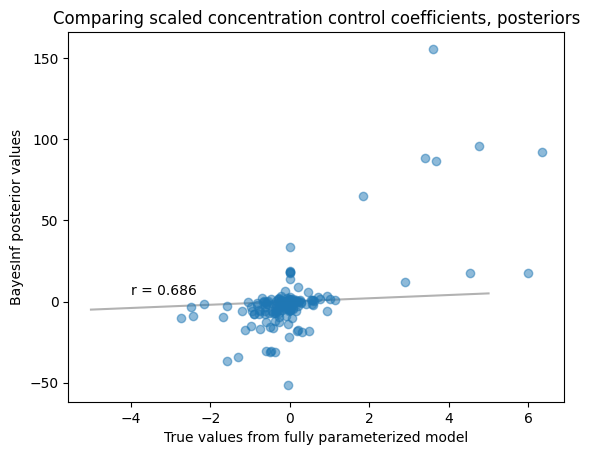

In [58]:
fig = plt.figure()

plt.scatter(gtCCC, postCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled concentration control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), postCCC.to_numpy().flatten())[0]).round(3)))

Text(-1, 2, 'r = -0.453')

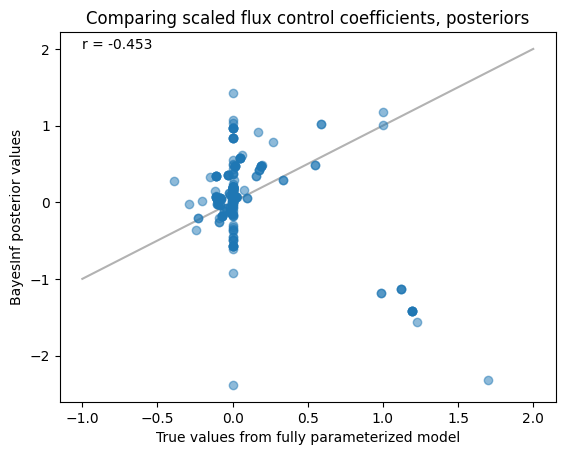

In [59]:
fig = plt.figure()

plt.scatter(gtFCC, postFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), postFCC.to_numpy().flatten())[0]).round(3)))

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



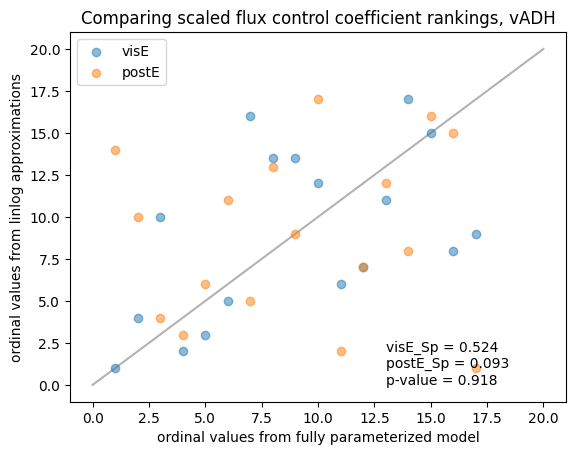

In [60]:
FCCrankings = pd.concat([gtFCC.loc['vADH'].rank(), visFCC.loc['vADH'].rank(), postFCC.loc['vADH'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings, vADH')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))
plt.legend()

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



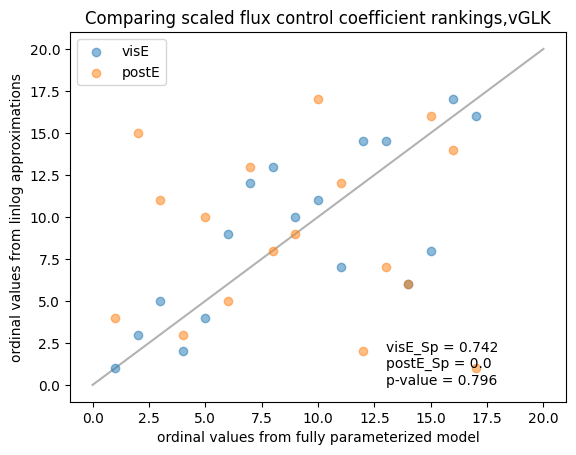

In [61]:
FCCrankings = pd.concat([gtFCC.loc['vGLK'].rank(), visFCC.loc['vGLK'].rank(), postFCC.loc['vGLK'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings,vGLK')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))

plt.legend()

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



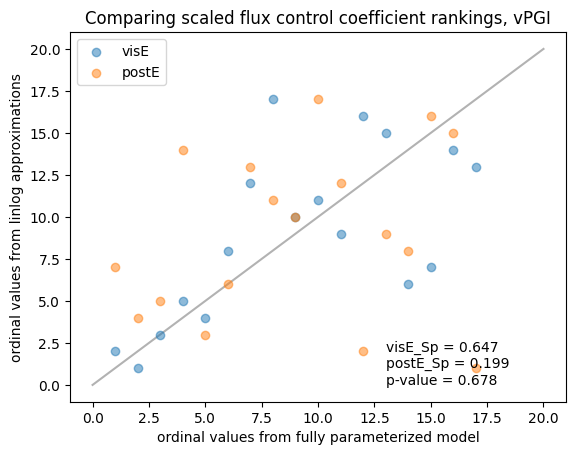

In [62]:
FCCrankings = pd.concat([gtFCC.loc['vPGI'].rank(), visFCC.loc['vPGI'].rank(), postFCC.loc['vPGI'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings, vPGI')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))

plt.legend()

## Distribution of FCC Sp. correlation coefficients

In [63]:
visE_r=[]
postE_r=[]

for i in r.getReactionIds():        
    FCCrankings = pd.concat([gtFCC.loc[i].rank(), visFCC.loc[i].rank(), postFCC.loc[i].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    visE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0])
    postE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0])


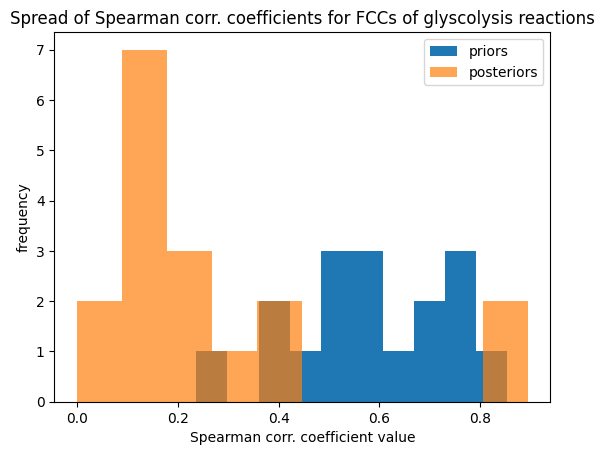

In [64]:
plt.hist(visE_r, label='priors')
plt.hist(postE_r, alpha=0.7, label='posteriors')
plt.legend()
plt.xlabel('Spearman corr. coefficient value')
plt.ylabel('frequency')
plt.title('Spread of Spearman corr. coefficients for FCCs of glyscolysis reactions')

plt.show()


# Solving for steady state concentrations using enzyme perturbation data

In [2]:
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/enzymeCompilation.csv'
df = pd.read_csv(data_file)
# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index) 

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

5.935978122618177e-12

In [ ]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

## Solving for steady state internal metabolite concentrations (X)

In [3]:
enzymes = [i for i in data.columns if 'e_' in i]

a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:]]
pt_enz.insert(0, 'e_vPGK')

C:\Users\user\AppData\Local\Temp\ipykernel_13308\4088482062.py:4: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [4]:
a = data[data[enzymes] != 1].values.flatten()
# a = data[enzymes].values.flatten()
pt_lvls = a[~np.isnan(a)]
pt_lvls = list(pt_lvls)
pt_lvls.insert(0, 1.0)

# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]

In [5]:
# get the real flux values
real_flux_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_flux_values = real_flux_values.div(real_flux_values.iloc[0])
# rel_real_flux_values.drop(rel_real_flux_values.index[0], inplace=True)
rel_real_flux_values.columns = r.getReactionIds()
rel_real_flux_values = rel_real_flux_values.transpose()
rel_real_flux_values.columns = enzPtLvls

PGK_flux_perts = rel_real_flux_values[[i for i in rel_real_flux_values.columns if 'e_vPGK' in i]] 
PGK_flux_perts.columns=[i[7:] for i in PGK_flux_perts.columns]
PGK_flux_perts = PGK_flux_perts.reindex(sorted(PGK_flux_perts.columns), axis=1)
PGK_flux_perts

,0.114,0.215,0.305,0.384,0.454,0.517,0.572,0.621,0.664,0.702,0.736,0.766,0.793,0.817,0.838,0.856,0.873,0.887,0.9,1.0,1.1,1.113,1.127,1.144,1.162,1.183,1.207,1.234,1.264,1.298,1.336,1.379,1.428,1.483,1.546,1.616,1.695,1.785,1.886,2.0
vGLK,0.997105,0.998633,0.999144,0.999397,0.999547,0.999648,0.999718,0.999770,0.999809,0.999840,0.999865,0.999885,0.999901,0.999915,0.999927,0.999936,0.999945,0.999952,0.999958,1.0,1.000034,1.000038,1.000043,1.000048,1.000053,1.000058,1.000065,1.000072,1.000079,1.000087,1.000095,1.000104,1.000113,1.000123,1.000134,1.000144,1.000155,1.000166,1.000178,1.000189
vPGI,0.996700,0.998442,0.999025,0.999312,0.999484,0.999599,0.999679,0.999738,0.999782,0.999817,0.999846,0.999869,0.999888,0.999904,0.999917,0.999928,0.999937,0.999945,0.999952,1.0,1.000039,1.000044,1.000049,1.000054,1.000060,1.000067,1.000074,1.000082,1.000090,1.000099,1.000108,1.000118,1.000129,1.000140,1.000152,1.000164,1.000177,1.000190,1.000203,1.000216
vGLYCO,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vTreha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vPFK,0.996700,0.998442,0.999025,0.999312,0.999484,0.999599,0.999679,0.999738,0.999782,0.999817,0.999846,0.999869,0.999888,0.999904,0.999917,0.999928,0.999937,0.999945,0.999952,1.0,1.000039,1.000044,1.000049,1.000054,1.000060,1.000067,1.000074,1.000082,1.000090,1.000099,1.000108,1.000118,1.000129,1.000140,1.000152,1.000164,1.000177,1.000190,1.000203,1.000216
vALD,0.996700,0.998442,0.999025,0.999312,0.999484,0.999599,0.999679,0.999738,0.999782,0.999817,0.999846,0.999869,0.999888,0.999904,0.999917,0.999928,0.999937,0.999945,0.999952,1.0,1.000039,1.000044,1.000049,1.000054,1.000060,1.000067,1.000074,1.000082,1.000090,1.000099,1.000108,1.000118,1.000129,1.000140,1.000152,1.000164,1.000177,1.000190,1.000203,1.000216
vGAPDH,0.989966,0.995174,0.996960,0.997850,0.998383,0.998741,0.998990,0.999176,0.999316,0.999426,0.999515,0.999586,0.999646,0.999697,0.999738,0.999772,0.999803,0.999827,0.999849,1.0,1.000123,1.000138,1.000153,1.000171,1.000189,1.000210,1.000233,1.000258,1.000284,1.000312,1.000342,1.000374,1.000408,1.000443,1.000481,1.000519,1.000558,1.000599,1.000640,1.000681
vPGK,0.989966,0.995174,0.996960,0.997850,0.998383,0.998741,0.998990,0.999176,0.999316,0.999426,0.999515,0.999586,0.999646,0.999697,0.999738,0.999772,0.999803,0.999827,0.999849,1.0,1.000123,1.000138,1.000153,1.000171,1.000189,1.000210,1.000233,1.000258,1.000284,1.000312,1.000342,1.000374,1.000408,1.000443,1.000481,1.000519,1.000558,1.000599,1.000640,1.000681
vPGM,0.989966,0.995174,0.996960,0.997850,0.998383,0.998741,0.998990,0.999176,0.999316,0.999426,0.999515,0.999586,0.999646,0.999697,0.999738,0.999772,0.999803,0.999827,0.999849,1.0,1.000123,1.000138,1.000153,1.000171,1.000189,1.000210,1.000233,1.000258,1.000284,1.000312,1.000342,1.000374,1.000408,1.000443,1.000481,1.000519,1.000558,1.000599,1.000640,1.000681
vENO,0.989966,0.995174,0.996960,0.997850,0.998383,0.998741,0.998990,0.999176,0.999316,0.999426,0.999515,0.999586,0.999646,0.999697,0.999738,0.999772,0.999803,0.999827,0.999849,1.0,1.000123,1.000138,1.000153,1.000171,1.000189,1.000210,1.000233,1.000258,1.000284,1.000312,1.000342,1.000374,1.000408,1.000443,1.000481,1.000519,1.000558,1.000599,1.000640,1.000681


In [6]:
# get the real inmet values
real_inmet_values = data[[i for i in data.columns if i in r.getFloatingSpeciesIds()]]
rel_real_inmet_values = real_inmet_values.div(real_inmet_values.iloc[0])
# rel_real_inmet_values.drop(rel_real_inmet_values.index[0], inplace=True)
rel_real_inmet_values = rel_real_inmet_values.transpose()
rel_real_inmet_values.columns = enzPtLvls
rel_real_inmet_values

PGK_inmet_perts = rel_real_inmet_values[[i for i in rel_real_inmet_values.columns if 'e_vPGK' in i]] 
PGK_inmet_perts.columns=[i[7:] for i in PGK_inmet_perts.columns]
PGK_inmet_perts = PGK_inmet_perts.reindex(sorted(PGK_inmet_perts.columns), axis=1)
PGK_inmet_perts

,0.114,0.215,0.305,0.384,0.454,0.517,0.572,0.621,0.664,0.702,0.736,0.766,0.793,0.817,0.838,0.856,0.873,0.887,0.9,1.0,1.1,1.113,1.127,1.144,1.162,1.183,1.207,1.234,1.264,1.298,1.336,1.379,1.428,1.483,1.546,1.616,1.695,1.785,1.886,2.0
P,0.980638,0.990680,0.994128,0.995845,0.996876,0.997568,0.998049,0.998407,0.998678,0.998890,0.999062,0.999201,0.999317,0.999414,0.999494,0.999559,0.999619,0.999666,0.999709,1.0,1.000239,1.000267,1.000296,1.000330,1.000366,1.000406,1.000450,1.000498,1.000549,1.000603,1.000661,1.000723,1.000788,1.000857,1.000929,1.001003,1.001079,1.001158,1.001237,1.001317
G6P,1.053093,1.022385,1.013453,1.009294,1.006888,1.005310,1.004230,1.003437,1.002841,1.002378,1.002005,1.001705,1.001455,1.001247,1.001075,1.000935,1.000808,1.000707,1.000617,1.0,0.999498,0.999440,0.999379,0.999306,0.999232,0.999148,0.999056,0.998957,0.998852,0.998738,0.998619,0.998492,0.998357,0.998215,0.998067,0.997915,0.997759,0.997599,0.997437,0.997275
TRIO,1.233142,1.104461,1.064282,1.044955,1.033574,1.026015,1.020800,1.016944,1.014035,1.011765,1.009936,1.008458,1.007224,1.006197,1.005347,1.004652,1.004022,1.003521,1.003071,1.0,0.997492,0.997199,0.996892,0.996528,0.996155,0.995735,0.995272,0.994773,0.994244,0.993674,0.993072,0.992430,0.991747,0.991033,0.990279,0.989511,0.988720,0.987905,0.987083,0.986255
NAD,1.001371,1.000682,1.000435,1.000309,1.000234,1.000182,1.000146,1.000120,1.000099,1.000084,1.000071,1.000060,1.000051,1.000044,1.000038,1.000033,1.000029,1.000025,1.000022,1.0,0.999982,0.999980,0.999978,0.999975,0.999972,0.999969,0.999966,0.999962,0.999958,0.999954,0.999950,0.999945,0.999940,0.999935,0.999930,0.999924,0.999918,0.999912,0.999906,0.999900
ACE,1.047199,1.022950,1.014509,1.010282,1.007740,1.006029,1.004838,1.003952,1.003280,1.002754,1.002329,1.001984,1.001696,1.001456,1.001257,1.001094,1.000947,1.000829,1.000723,1.0,0.999407,0.999338,0.999265,0.999179,0.999090,0.998990,0.998880,0.998762,0.998636,0.998500,0.998356,0.998203,0.998040,0.997870,0.997689,0.997505,0.997316,0.997120,0.996923,0.996723
P2G,0.958816,0.979587,0.987005,0.990758,0.993028,0.994561,0.995631,0.996429,0.997034,0.997508,0.997892,0.998204,0.998464,0.998681,0.998861,0.999009,0.999142,0.999249,0.999345,1.0,1.000538,1.000601,1.000667,1.000746,1.000826,1.000917,1.001016,1.001124,1.001239,1.001362,1.001493,1.001632,1.001780,1.001935,1.002100,1.002267,1.002440,1.002618,1.002798,1.002980
BPG,3.931396,2.295087,1.792990,1.553184,1.412508,1.319309,1.255120,1.207711,1.171986,1.144125,1.121678,1.103558,1.088438,1.075852,1.065439,1.056925,1.049215,1.043086,1.037573,1.0,0.969339,0.965762,0.962002,0.957563,0.953009,0.947869,0.942216,0.936124,0.929664,0.922703,0.915351,0.907523,0.899182,0.890480,0.881283,0.871910,0.862268,0.852331,0.842318,0.832238
GLCi,1.040187,1.018943,1.011851,1.008355,1.006270,1.004874,1.003906,1.003187,1.002643,1.002218,1.001874,1.001597,1.001364,1.001171,1.001011,1.000880,1.000761,1.000666,1.000581,1.0,0.999524,0.999469,0.999410,0.999341,0.999270,0.999190,0.999102,0.999007,0.998907,0.998798,0.998683,0.998561,0.998431,0.998295,0.998151,0.998004,0.997852,0.997696,0.997539,0.997380
F6P,1.093222,1.039503,1.023788,1.016450,1.012201,1.009409,1.007498,1.006093,1.005038,1.004217,1.003557,1.003025,1.002581,1.002213,1.001908,1.001659,1.001434,1.001255,1.001094,1.0,0.999110,0.999006,0.998897,0.998768,0.998636,0.998488,0.998324,0.998148,0.997961,0.997760,0.997548,0.997322,0.997082,0.996831,0.996566,0.996297,0.996020,0.995734,0.995447,0.995158
PEP,0.937331,0.968722,0.980039,0.985787,0.989270,0.991626,0.993271,0.994498,0.995429,0.996160,0.996752,0.997231,0.997632,0.997967,0.998244,0.998471,0.998677,0.998841,0.998989,1.0,1.000830,1.000927,1.001029,1.001150,1.001274,1.001414,1.001568,1.001735,1.001911,1.002102,1.002303,1.002518,1.002747,1.002987,1.003240,1.003499,1.003766,1.004041,1.004320,1.004600


In [7]:
# get the real exmet values
real_exmet_values = data[[i for i in data.columns if i in r.getBoundarySpeciesIds()]]
rel_real_exmet_values = real_exmet_values.div(real_exmet_values.iloc[0])
# rel_real_exmet_values.drop(rel_real_exmet_values.index[0], inplace=True)
rel_real_exmet_values = rel_real_exmet_values.transpose()
rel_real_exmet_values.columns = enzPtLvls
rel_real_exmet_values

PGK_exmet_perts = rel_real_exmet_values[[i for i in rel_real_exmet_values.columns if 'e_vPGK' in i]] 
PGK_exmet_perts.columns=[i[7:] for i in PGK_exmet_perts.columns]
PGK_exmet_perts = PGK_exmet_perts.reindex(sorted(PGK_exmet_perts.columns), axis=1)
PGK_exmet_perts

,0.114,0.215,0.305,0.384,0.454,0.517,0.572,0.621,0.664,0.702,0.736,0.766,0.793,0.817,0.838,0.856,0.873,0.887,0.9,1.0,1.1,1.113,1.127,1.144,1.162,1.183,1.207,1.234,1.264,1.298,1.336,1.379,1.428,1.483,1.546,1.616,1.695,1.785,1.886,2.0
CO2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
GLCo,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ETOH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
GLY,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
F26BP,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [11]:
N = r.getFullStoichiometryMatrix()
BIOMD64.v_star
# e_hat is the PGK_perts column names
Ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
Ey = np.array(c).reshape((len(b),len(a)))


In [9]:
e_hat = [float(i) for i in PGK_flux_perts.columns]

In [50]:
Xss=[]

for e in e_hat:
    e_vector = np.ones(len(r.getReactionIds()))
    e_vector[r.getReactionIds().index('vPGK')] = e

    A = N @ np.diag(BIOMD64.v_star * e_vector) @ Ex # 14, 5
    b = -N @ np.diag(BIOMD64.v_star * e_vector) @ (np.ones((len(N.T), 1)) + (Ey @ np.log(PGK_exmet_perts[str(e)]).values.reshape((-1,1)))) # 14, 641

    Xss.append(np.exp(sp.linalg.pinv(A) @ b))

In [61]:
Xss = pd.DataFrame(np.squeeze(np.array(Xss)).T, columns=e_hat, index=r.getFloatingSpeciesIds())
Xss

,0.114,0.215,0.305,0.384,0.454,0.517,0.572,0.621,0.664,0.702,0.736,0.766,0.793,0.817,0.838,0.856,0.873,0.887,0.900,1.000,1.100,1.113,1.127,1.144,1.162,1.183,1.207,1.234,1.264,1.298,1.336,1.379,1.428,1.483,1.546,1.616,1.695,1.785,1.886,2.000
P,0.967077,0.984802,0.990576,0.993388,0.995053,0.996162,0.996929,0.997497,0.997926,0.998261,0.998531,0.998749,0.998931,0.999083,0.999209,0.999312,0.999405,0.999479,0.999545,1.0,1.000371,1.000415,1.000460,1.000514,1.000570,1.000632,1.000701,1.000774,1.000853,1.000937,1.001027,1.001122,1.001223,1.001329,1.001441,1.001555,1.001673,1.001794,1.001916,1.002039
G6P,0.994088,0.999200,0.999923,1.000093,1.000136,1.000140,1.000131,1.000119,1.000106,1.000094,1.000082,1.000072,1.000063,1.000056,1.000049,1.000043,1.000038,1.000033,1.000029,1.0,0.999973,0.999970,0.999967,0.999963,0.999958,0.999954,0.999948,0.999942,0.999936,0.999929,0.999921,0.999913,0.999904,0.999894,0.999884,0.999873,0.999862,0.999850,0.999838,0.999826
TRIO,1.185385,1.085844,1.053286,1.037408,1.027998,1.021724,1.017386,1.014172,1.011745,1.009849,1.008320,1.007084,1.006052,1.005193,1.004481,1.003899,1.003371,1.002952,1.002574,1.0,0.997895,0.997650,0.997392,0.997086,0.996773,0.996420,0.996031,0.995612,0.995167,0.994688,0.994182,0.993643,0.993068,0.992468,0.991834,0.991187,0.990521,0.989835,0.989143,0.988446
NAD,1.460650,1.178129,1.104391,1.071273,1.052473,1.040272,1.031986,1.025928,1.021397,1.017884,1.015067,1.012802,1.010917,1.009352,1.008061,1.007006,1.006053,1.005296,1.004616,1.0,0.996257,0.995822,0.995365,0.994826,0.994273,0.993650,0.992965,0.992228,0.991447,0.990607,0.989720,0.988778,0.987775,0.986731,0.985630,0.984509,0.983358,0.982174,0.980984,0.979788
ACE,1.087393,1.039058,1.023968,1.016732,1.012482,1.009664,1.007722,1.006288,1.005206,1.004363,1.003684,1.003135,1.002678,1.002297,1.001981,1.001724,1.001490,1.001305,1.001138,1.0,0.999072,0.998963,0.998849,0.998715,0.998577,0.998422,0.998250,0.998066,0.997870,0.997659,0.997437,0.997200,0.996947,0.996684,0.996405,0.996121,0.995829,0.995528,0.995225,0.994920
P2G,0.927632,0.966210,0.978971,0.985218,0.988928,0.991405,0.993119,0.994390,0.995350,0.996100,0.996705,0.997194,0.997603,0.997943,0.998225,0.998455,0.998664,0.998830,0.998980,1.0,1.000834,1.000932,1.001034,1.001155,1.001279,1.001419,1.001573,1.001740,1.001916,1.002106,1.002307,1.002521,1.002749,1.002987,1.003238,1.003495,1.003759,1.004031,1.004306,1.004583
BPG,12.304266,3.297662,2.111812,1.694257,1.485440,1.360186,1.279547,1.222792,1.181537,1.150242,1.125576,1.106012,1.089926,1.076696,1.065861,1.057077,1.049175,1.042937,1.037349,1.0,0.970428,0.967031,0.963473,0.959285,0.955004,0.950196,0.944934,0.939291,0.933339,0.926969,0.920279,0.913205,0.905723,0.897978,0.889855,0.881646,0.873274,0.864722,0.856179,0.847657
GLCi,1.066483,1.029946,1.018423,1.012878,1.009614,1.007447,1.005953,1.004848,1.004015,1.003365,1.002842,1.002419,1.002066,1.001772,1.001529,1.001330,1.001150,1.001007,1.000878,1.0,0.999283,0.999200,0.999112,0.999008,0.998901,0.998781,0.998649,0.998506,0.998355,0.998193,0.998021,0.997837,0.997642,0.997439,0.997223,0.997004,0.996778,0.996546,0.996311,0.996075
F6P,0.997583,1.002087,1.001988,1.001639,1.001336,1.001093,1.000907,1.000758,1.000640,1.000545,1.000466,1.000400,1.000345,1.000298,1.000258,1.000226,1.000196,1.000172,1.000150,1.0,0.999873,0.999858,0.999842,0.999823,0.999803,0.999781,0.999757,0.999731,0.999702,0.999672,0.999639,0.999604,0.999567,0.999527,0.999485,0.999442,0.999397,0.999350,0.999303,0.999255
PEP,0.890436,0.948290,0.967705,0.977260,0.982951,0.986756,0.989392,0.991348,0.992826,0.993982,0.994915,0.995669,0.996300,0.996825,0.997260,0.997615,0.997938,0.998194,0.998425,1.0,1.001289,1.001439,1.001597,1.001784,1.001976,1.002193,1.002431,1.002688,1.002961,1.003254,1.003565,1.003896,1.004248,1.004617,1.005006,1.005403,1.005812,1.006233,1.006659,1.007087


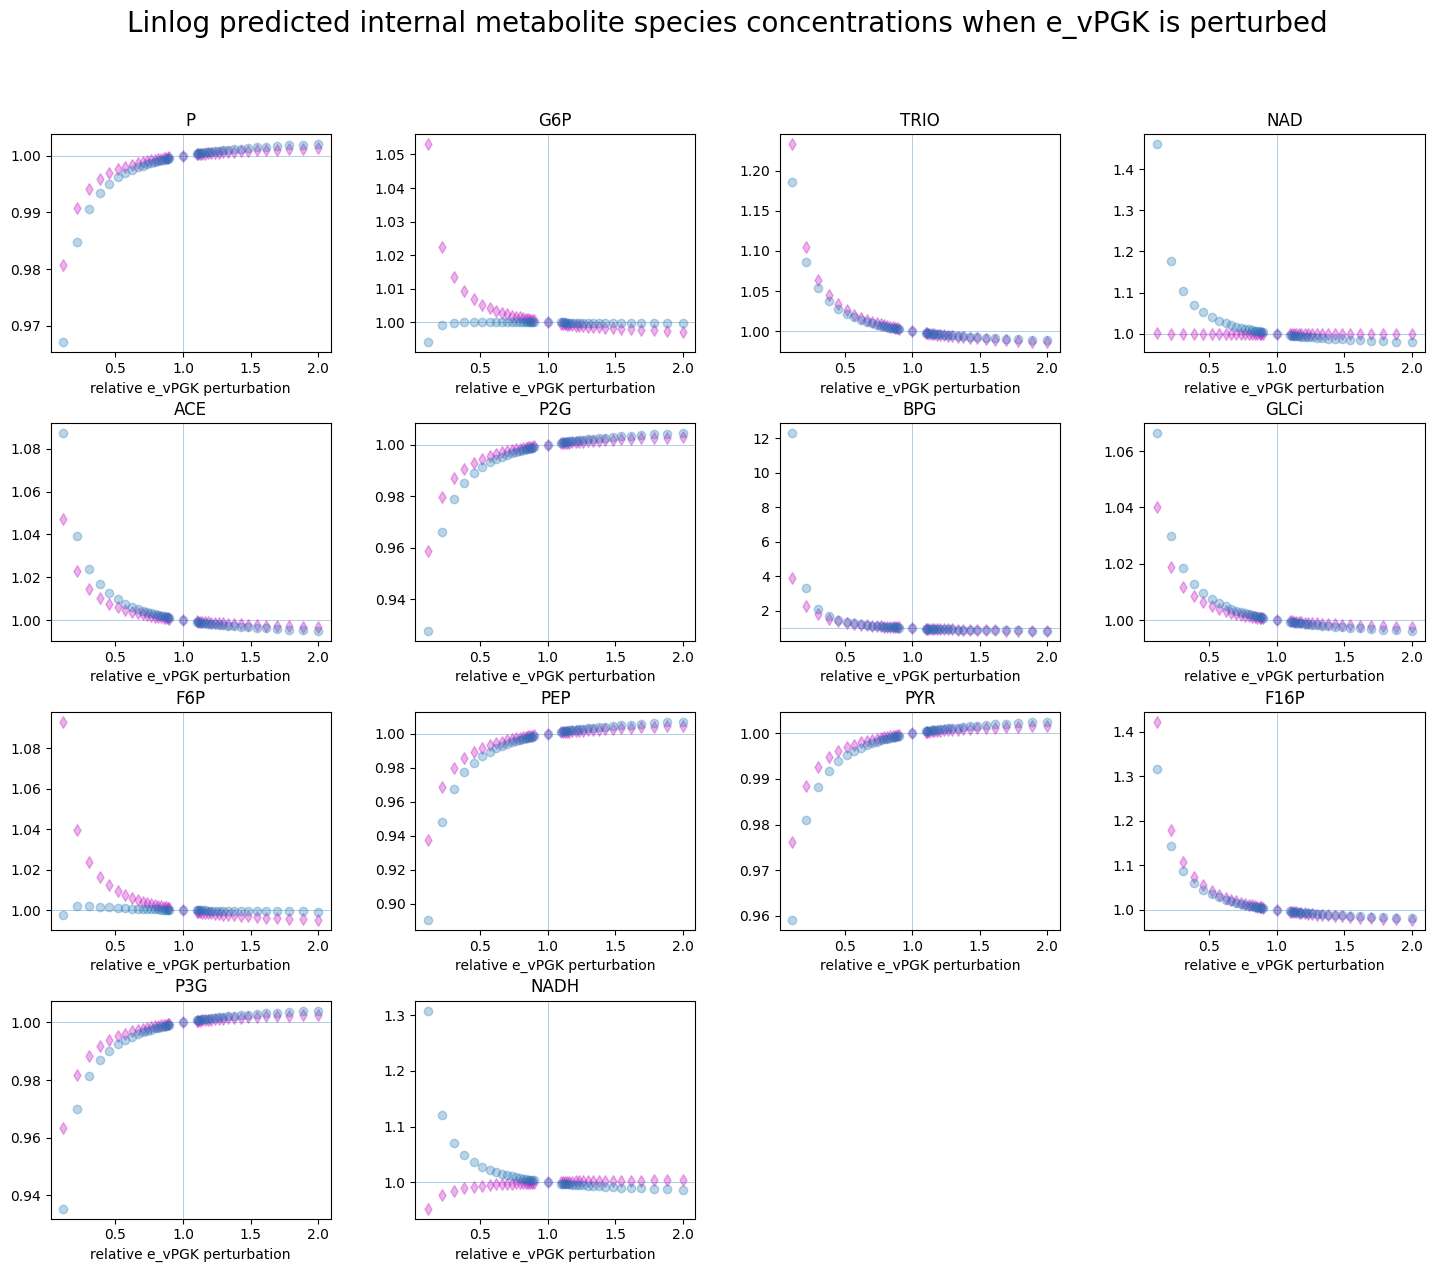

In [62]:
Xss.index = r.getFloatingSpeciesIds()
# plot for each metabolite 
# create a subplot that is (3,2)
fig, axs = plt.subplots(4,4, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Linlog predicted internal metabolite species concentrations when e_vPGK is perturbed\n', fontsize = 20)
fig.tight_layout(pad=3.0)

for i,met in enumerate(r.getFloatingSpeciesIds()):
    if i%4==0:
        idx_starter += 1

    axs[idx_starter, i%4].scatter(Xss.columns, PGK_inmet_perts.loc[met], alpha=0.3, c='m', marker='d')
    axs[idx_starter, i%4].scatter(Xss.columns, Xss.loc[met], alpha=0.3)
    axs[idx_starter, i%4].set_xlabel('relative e_vPGK perturbation')
    axs[idx_starter, i%4].set_title(met)

    axs[idx_starter, i%4].axhline(1, linewidth=0.5, zorder=0, alpha=0.5)
    axs[idx_starter, i%4].axvline(x=1, linewidth=0.5, zorder=0, alpha=0.5)
  
fig.delaxes(axs[3,2]) 
fig.delaxes(axs[3,3]) 


## Solving for steady state external metabolite concentrations (Y)

In [64]:
Yss=[]

for e in e_hat:
    e_vector = np.ones(len(r.getReactionIds()))
    e_vector[r.getReactionIds().index('vPGK')] = e

    A = N @ np.diag(BIOMD64.v_star * e_vector) @ Ey # 14, 5
    b = -N @ np.diag(BIOMD64.v_star * e_vector) @ (np.ones((len(N.T), 1)) + (Ex @ np.log(PGK_inmet_perts[str(e)]).values.reshape((-1,1)))) # 14, 641
    
    Yss.append(np.exp(sp.linalg.pinv(A) @ b))

In [65]:
Yss = pd.DataFrame(np.squeeze(np.array(Yss)).T, columns=e_hat, index=r.getBoundarySpeciesIds())
Yss

,0.114,0.215,0.305,0.384,0.454,0.517,0.572,0.621,0.664,0.702,0.736,0.766,0.793,0.817,0.838,0.856,0.873,0.887,0.900,1.000,1.100,1.113,1.127,1.144,1.162,1.183,1.207,1.234,1.264,1.298,1.336,1.379,1.428,1.483,1.546,1.616,1.695,1.785,1.886,2.000
CO2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GLCo,1.001635,1.000325,1.000122,1.000060,1.000033,1.000020,1.000013,1.000008,1.000006,1.000004,1.000003,1.000002,1.000001,1.000001,1.000001,1.000001,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000001,1.000001,1.000001,1.000001,1.000001,1.000002,1.000002,1.000002,1.000003,1.000003,1.000004,1.000004,1.000005,1.000005
ETOH,0.976230,0.991963,0.996213,0.997909,0.998739,0.999200,0.999468,0.999636,0.999744,0.999817,0.999867,0.999903,0.999928,0.999947,0.999960,0.999970,0.999977,0.999982,0.999987,1.0,0.999991,0.999988,0.999985,0.999982,0.999978,0.999972,0.999966,0.999958,0.999949,0.999938,0.999925,0.999910,0.999892,0.999872,0.999848,0.999822,0.999792,0.999759,0.999723,0.999683
GLY,2.213468,1.538793,1.258799,1.144212,1.087670,1.056036,1.037512,1.025808,1.018217,1.013097,1.009521,1.007004,1.005180,1.003853,1.002896,1.002213,1.001661,1.001286,1.000979,1.0,1.000698,1.000876,1.001086,1.001361,1.001670,1.002069,1.002560,1.003149,1.003840,1.004680,1.005654,1.006810,1.008173,1.009750,1.011576,1.013629,1.015950,1.018564,1.021432,1.024574
F26BP,0.687723,0.796057,0.860980,0.902058,0.929547,0.948790,0.962160,0.971818,0.978792,0.983925,0.987783,0.990668,0.992872,0.994548,0.995805,0.996733,0.997501,0.998039,0.998485,1.0,0.998704,0.998359,0.997945,0.997390,0.996748,0.995908,0.994849,0.993540,0.991950,0.989965,0.987565,0.984610,0.980968,0.976558,0.971163,0.964761,0.957091,0.947881,0.937055,0.924323


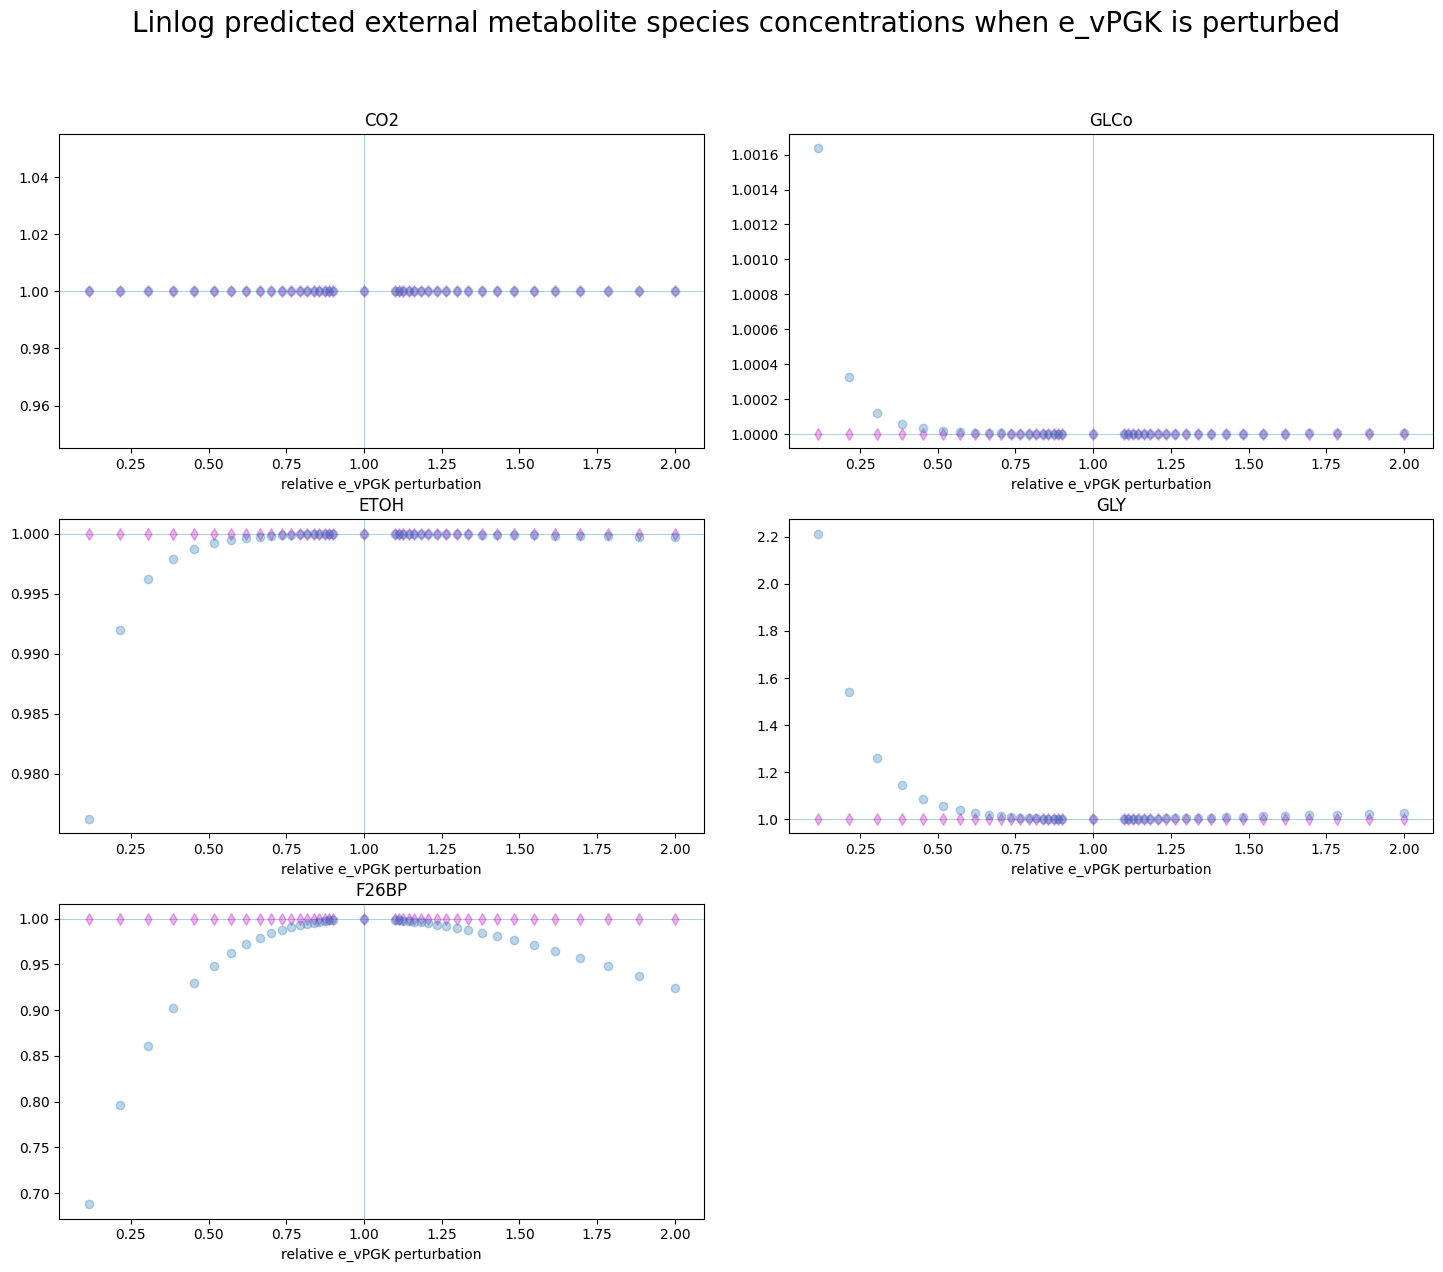

In [68]:
# establish the names of each boundary specie
Yss.index = r.getBoundarySpeciesIds()
# plot for each metabolite 
# create a subplot that is (3,2)
fig, axs = plt.subplots(3,2, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Linlog predicted external metabolite species concentrations when e_vPGK is perturbed\n', fontsize = 20)
fig.tight_layout(pad=3.0)

for i,met in enumerate(r.getBoundarySpeciesIds()):
    if i%2==0:
        idx_starter += 1

    axs[idx_starter, i%2].scatter(Yss.columns, PGK_exmet_perts.loc[met], alpha=0.3, c='m', marker='d')
    axs[idx_starter, i%2].scatter(Yss.columns, Yss.loc[met], alpha=0.3)
    axs[idx_starter, i%2].set_xlabel('relative e_vPGK perturbation')
    axs[idx_starter, i%2].set_title(met)
  
    axs[idx_starter, i%2].axhline(1, linewidth=0.5, zorder=0, alpha=0.5)
    axs[idx_starter, i%2].axvline(x=1, linewidth=0.5, zorder=0, alpha=0.5)

fig.delaxes(axs[2,1]) 
